In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import fastparquet
import glob
import dask.dataframe as dd
import missingno as msno
from statsmodels.tsa.seasonal import seasonal_decompose

In [3]:
# Load the final merged dataset
df = pd.read_parquet("final_dataset.parquet", engine="fastparquet")

In [10]:
df.head()

date            building_id  daily_consumption site_id    sqft  \
0 2016-01-01  Robin_public_Carolina           2183.750   Robin  118231   
1 2016-01-02  Robin_public_Carolina           2205.563   Robin  118231   
2 2016-01-03  Robin_public_Carolina           2108.750   Robin  118231   
3 2016-01-04  Robin_public_Carolina           3536.562   Robin  118231   
4 2016-01-05  Robin_public_Carolina           3771.376   Robin  118231   

       sqm       timezone sub_primaryspaceusage primaryspaceusage       lat  \
0  10984.0  Europe/London               Library   Public services  51.51879   
1  10984.0  Europe/London               Library   Public services  51.51879   
2  10984.0  Europe/London               Library   Public services  51.51879   
3  10984.0  Europe/London               Library   Public services  51.51879   
4  10984.0  Europe/London               Library   Public services  51.51879   

        lng  has_location  airTemperature  dewTemperature  seaLvlPressure  \
0 -0.134556             1        5.387500        3.879167     1016.941667   
1 -0.134556             1        9.783333        9.183333      998.087500   
2 -0.134556             1        7.954167        6.687500      991.837500   
3 -0.134556             1        7.841667        6.508333      982.766667   
4 -0.134556             1        7.904167        7.058333      984.712500   

   windDirection  windSpeed  
0     116.666667   4.470833  
1     166.666667   7.241667  
2     187.916667   5.633333  
3     177.083333   4.145833  
4     175.416667   2.750000

<font size="6">Data Quality/Sanity Checks  </font>

In [3]:
print("Shape:", df.shape)

Shape: (918136, 17)


In [5]:
print("--- Dataset Info ---")
print(df.info())

--- Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918136 entries, 0 to 918135
Data columns (total 17 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   date                   918136 non-null  datetime64[ns]
 1   building_id            918136 non-null  object        
 2   daily_consumption      918136 non-null  float64       
 3   site_id                918136 non-null  object        
 4   sqft                   918136 non-null  int64         
 5   sqm                    918136 non-null  float64       
 6   timezone               918136 non-null  object        
 7   sub_primaryspaceusage  918136 non-null  object        
 8   primaryspaceusage      918136 non-null  object        
 9   lat                    798983 non-null  float64       
 10  lng                    798983 non-null  float64       
 11  has_location           918136 non-null  int64         
 12  airTemperature         

In [6]:
print("--- Date Range ---")
print("Min date:", df["date"].min())
print("Max date:", df["date"].max())

--- Date Range ---
Min date: 2016-01-01 00:00:00
Max date: 2017-12-31 00:00:00


In [7]:
print("--- Unique Counts ---")
print("Buildings:", df["building_id"].nunique())
print("Sites:", df["site_id"].nunique())

--- Unique Counts ---
Buildings: 1256
Sites: 16


In [8]:
print("--- Missing Values (% per column) ---")
missing = df.isna().mean().sort_values(ascending=False) * 100
print(missing)

--- Missing Values (% per column) ---
lat                      12.977707
lng                      12.977707
windSpeed                 0.014159
windDirection             0.014159
seaLvlPressure            0.014159
dewTemperature            0.014159
airTemperature            0.014159
has_location              0.000000
date                      0.000000
building_id               0.000000
sub_primaryspaceusage     0.000000
timezone                  0.000000
sqm                       0.000000
sqft                      0.000000
site_id                   0.000000
daily_consumption         0.000000
primaryspaceusage         0.000000
dtype: float64


In [9]:
print("--- Summary Stats ---")
print(df.describe())

--- Summary Stats ---
                                date  daily_consumption           sqft  \
count                         918136       9.181360e+05  918136.000000   
mean   2016-12-30 23:59:59.999998976       3.603648e+03   91480.423567   
min              2016-01-01 00:00:00       2.400000e-03     356.000000   
25%              2016-07-01 00:00:00       4.944575e+02   22300.750000   
50%              2016-12-31 00:00:00       1.506945e+03   56982.000000   
75%              2017-07-02 00:00:00       3.848711e+03  116137.250000   
max              2017-12-31 00:00:00       4.576159e+06  875000.000000   
std                              NaN       1.123524e+04  111225.139156   

                 sqm            lat            lng   has_location  \
count  918136.000000  798983.000000  798983.000000  918136.000000   
mean     8498.805971      41.011213     -73.633635       0.870223   
min        33.100000      30.267200    -122.260729       0.000000   
25%      2071.800000      37.871903

In [12]:
print("---- Outlier check: negative values ----")
negatives = (df["daily_consumption"] < 0).sum()
print(f"Negative consumption readings: {negatives}")

---- Outlier check: negative values ----
Negative consumption readings: 0


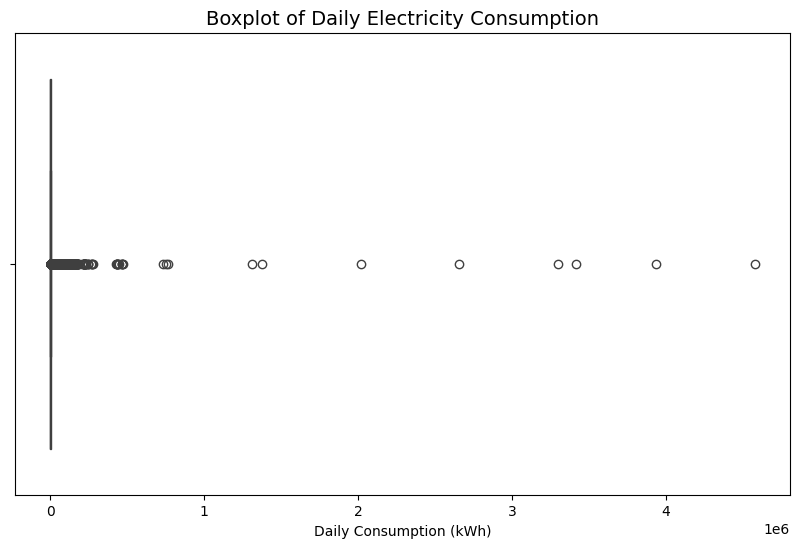

In [18]:
# Boxplot of Daily Consumption Distribution
plt.figure(figsize=(10,6))
sns.boxplot(x=df["daily_consumption"])
plt.title("Boxplot of Daily Electricity Consumption", fontsize=14)
plt.xlabel("Daily Consumption (kWh)")
plt.show()

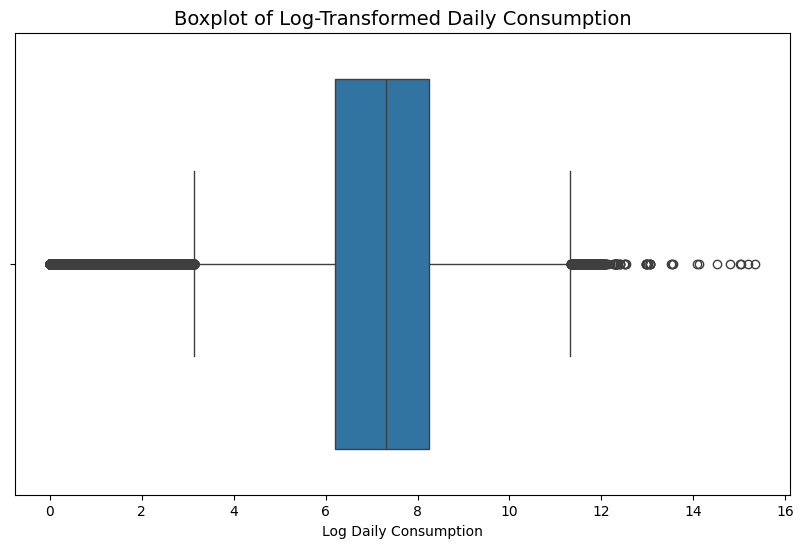

In [19]:
#Log transform for inspection
plt.figure(figsize=(10,6))
sns.boxplot(x=np.log1p(df["daily_consumption"]))  # log(1+x)
plt.title("Boxplot of Log-Transformed Daily Consumption", fontsize=14)
plt.xlabel("Log Daily Consumption")
plt.show()

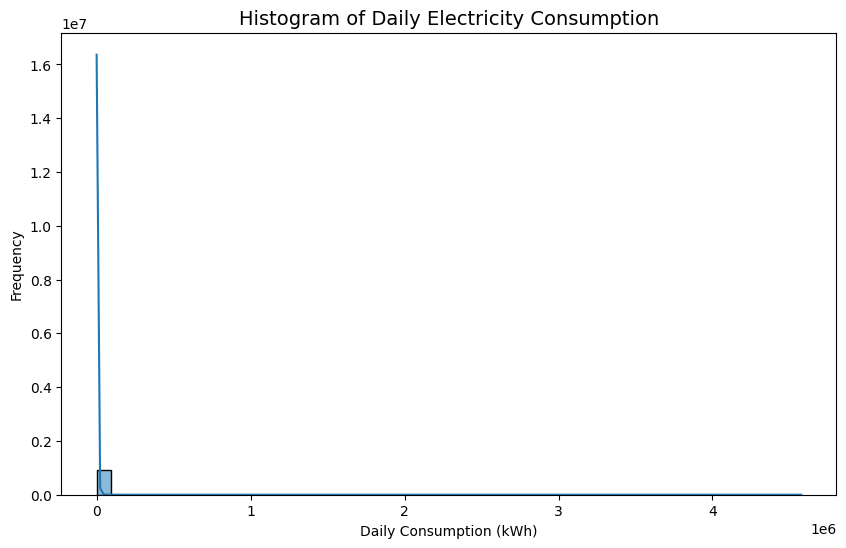

In [20]:
# Histogram of Daily Consumption
plt.figure(figsize=(10,6))
sns.histplot(df["daily_consumption"], bins=50, kde=True)
plt.title("Histogram of Daily Electricity Consumption", fontsize=14)
plt.xlabel("Daily Consumption (kWh)")
plt.ylabel("Frequency")
plt.show()

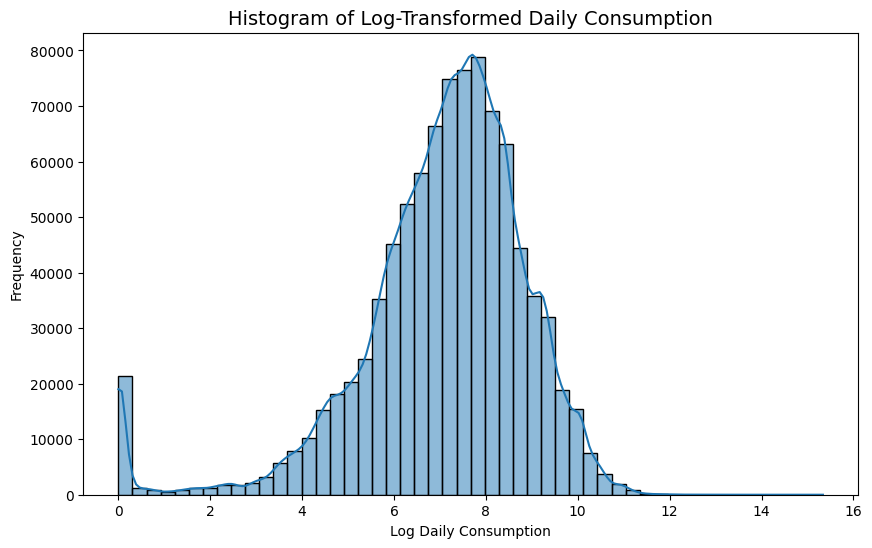

In [21]:
#Histogram (Log-Transformed)
plt.figure(figsize=(10,6))
sns.histplot(np.log1p(df["daily_consumption"]), bins=50, kde=True)
plt.title("Histogram of Log-Transformed Daily Consumption", fontsize=14)
plt.xlabel("Log Daily Consumption")
plt.ylabel("Frequency")
plt.show()

<font size="6">Time-Based / Seasonal Analysis</font>

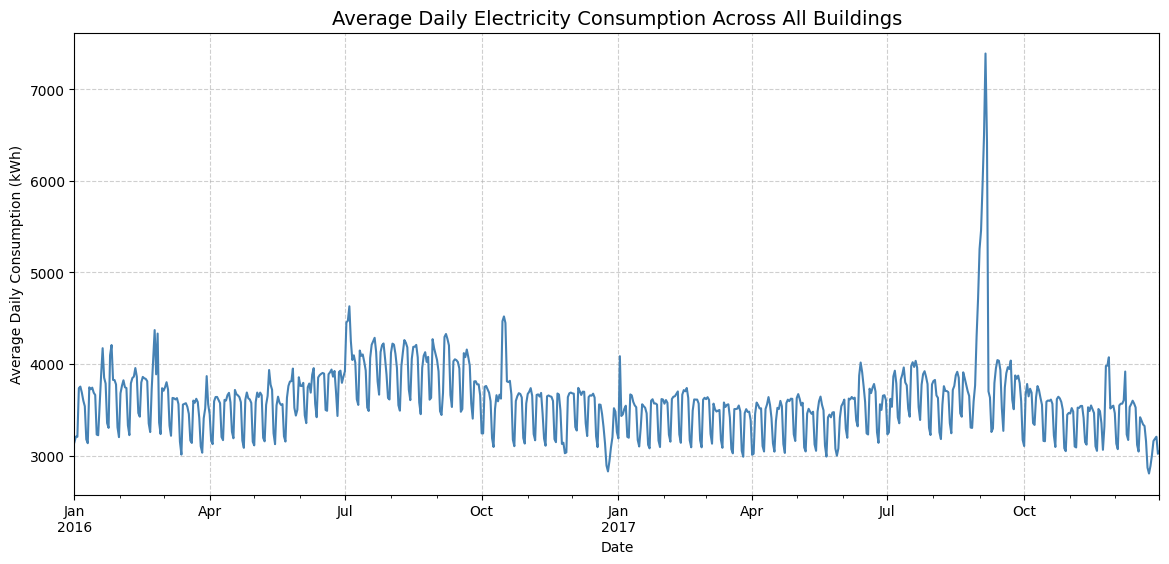

In [24]:
# Group by date → average daily consumption across all buildings
daily_trend = df.groupby("date")["daily_consumption"].mean()

# Plot
plt.figure(figsize=(14,6))
daily_trend.plot(color="steelblue", linewidth=1.5)

plt.title("Average Daily Electricity Consumption Across All Buildings", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Average Daily Consumption (kWh)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

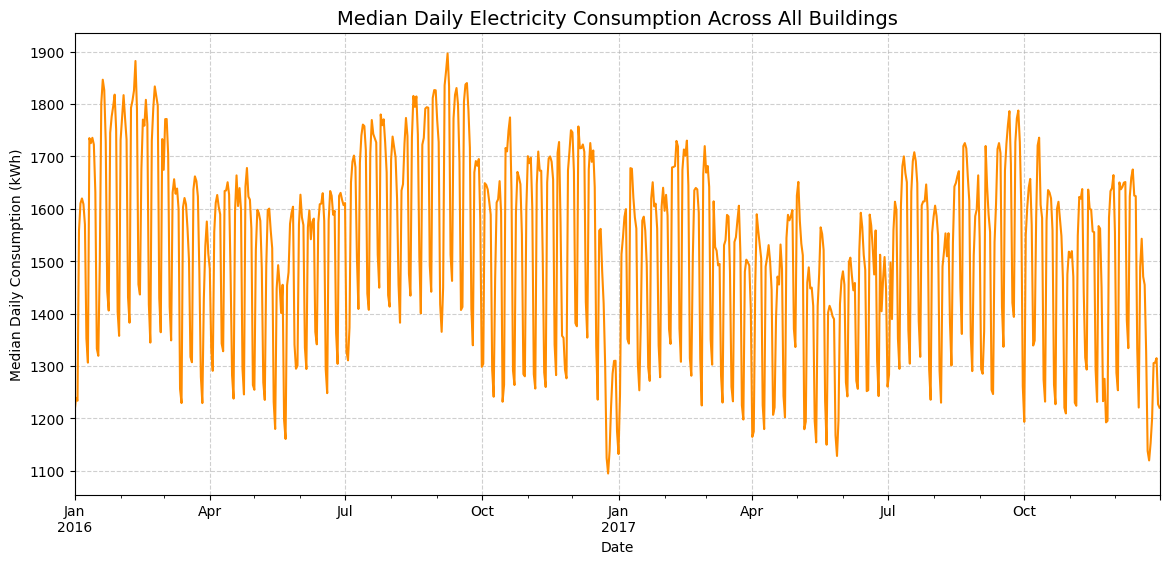

In [25]:
# Group by date → median daily consumption across all buildings
daily_trend_median = df.groupby("date")["daily_consumption"].median()

# Plot
plt.figure(figsize=(14,6))
daily_trend_median.plot(color="darkorange", linewidth=1.5)

plt.title("Median Daily Electricity Consumption Across All Buildings", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Median Daily Consumption (kWh)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


<font size="4">Flagging Outliers</font>

In [4]:
# Median daily consumption per building
building_medians = df.groupby("building_id")["daily_consumption"].median().reset_index()
building_medians.rename(columns={"daily_consumption": "median_daily_consumption"}, inplace=True)


In [5]:
threshold = building_medians["median_daily_consumption"].quantile(0.99)
building_medians["is_outlier"] = building_medians["median_daily_consumption"] > threshold

In [6]:
outlier_buildings = building_medians[building_medians["is_outlier"]]
print(outlier_buildings.sort_values("median_daily_consumption", ascending=False).head(50))
print(outlier_buildings["is_outlier"].value_counts())

                  building_id  median_daily_consumption  is_outlier
613      Hog_education_Janell                71963.0000        True
486      Fox_education_Willis                56397.8100        True
1058         Rat_office_Colby                52043.2400        True
337     Eagle_education_Peter                37577.6808        True
62      Bear_education_Wilton                37254.5961        True
548   Gator_assembly_Kimberly                35578.0008        True
694            Hog_office_Nia                35017.3440        True
1040           Rat_health_Guy                33926.1600        True
124     Bull_education_Dottie                33045.0000        True
14       Bear_education_Bulah                31637.7600        True
661        Hog_office_Cornell                31323.6510        True
860     Moose_education_Abbie                30740.3135        True
862    Moose_education_Gladys                28669.3701        True
is_outlier
True    13
Name: count, dtype: int64


In [7]:
selected_rows = df.loc[ (df['building_id'] == 'Hog_education_Janell') & (df['date'] > '2016-09-01' )]

print(selected_rows)

             date           building_id  daily_consumption site_id    sqft  \
703467 2016-09-02  Hog_education_Janell            76259.4     Hog  287594   
703468 2016-09-03  Hog_education_Janell            71718.6     Hog  287594   
703469 2016-09-04  Hog_education_Janell            93420.7     Hog  287594   
703470 2016-09-05  Hog_education_Janell           145094.7     Hog  287594   
703471 2016-09-06  Hog_education_Janell           172186.9     Hog  287594   
...           ...                   ...                ...     ...     ...   
703948 2017-12-27  Hog_education_Janell            82731.4     Hog  287594   
703949 2017-12-28  Hog_education_Janell            82245.1     Hog  287594   
703950 2017-12-29  Hog_education_Janell            80920.0     Hog  287594   
703951 2017-12-30  Hog_education_Janell            80468.0     Hog  287594   
703952 2017-12-31  Hog_education_Janell            80463.0     Hog  287594   

            sqm    timezone sub_primaryspaceusage primaryspaceu

In [8]:
df = df.merge(building_medians[["building_id", "is_outlier"]], on="building_id", how="left")
print(df["is_outlier"].value_counts())

is_outlier
False    908633
True       9503
Name: count, dtype: int64


In [9]:
df.head()

date            building_id  daily_consumption site_id    sqft  \
0 2016-01-01  Robin_public_Carolina           2183.750   Robin  118231   
1 2016-01-02  Robin_public_Carolina           2205.563   Robin  118231   
2 2016-01-03  Robin_public_Carolina           2108.750   Robin  118231   
3 2016-01-04  Robin_public_Carolina           3536.562   Robin  118231   
4 2016-01-05  Robin_public_Carolina           3771.376   Robin  118231   

       sqm       timezone sub_primaryspaceusage primaryspaceusage       lat  \
0  10984.0  Europe/London               Library   Public services  51.51879   
1  10984.0  Europe/London               Library   Public services  51.51879   
2  10984.0  Europe/London               Library   Public services  51.51879   
3  10984.0  Europe/London               Library   Public services  51.51879   
4  10984.0  Europe/London               Library   Public services  51.51879   

        lng  has_location  airTemperature  dewTemperature  seaLvlPressure  \
0 -0.134556             1        5.387500        3.879167     1016.941667   
1 -0.134556             1        9.783333        9.183333      998.087500   
2 -0.134556             1        7.954167        6.687500      991.837500   
3 -0.134556             1        7.841667        6.508333      982.766667   
4 -0.134556             1        7.904167        7.058333      984.712500   

   windDirection  windSpeed  is_outlier  
0     116.666667   4.470833       False  
1     166.666667   7.241667       False  
2     187.916667   5.633333       False  
3     177.083333   4.145833       False  
4     175.416667   2.750000       False

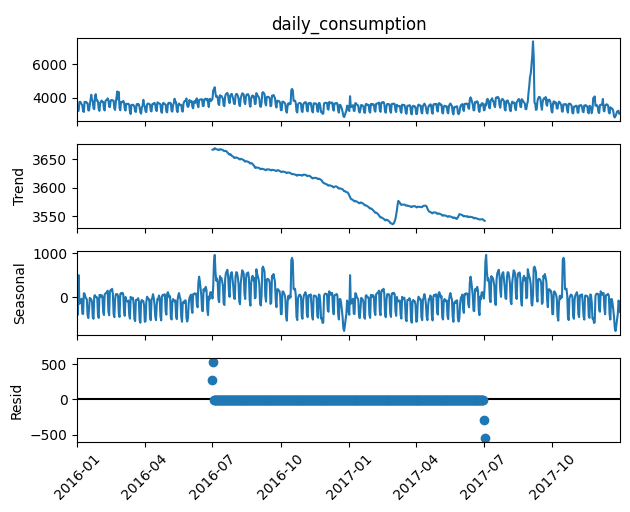

In [10]:
# Create average daily series across all buildings
series = df.groupby("date")["daily_consumption"].mean()

# Seasonal decomposition (assume yearly seasonality = 365 days)
result = seasonal_decompose(series, model="additive", period=365)

# Plot decomposition
result.plot().suptitle(' ', fontsize=14)
plt.xticks(rotation=45)
plt.show()

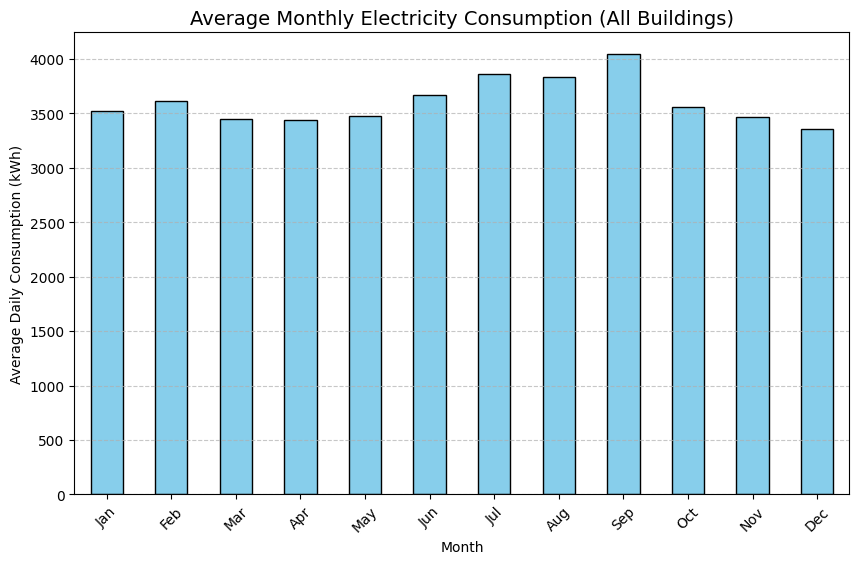

In [11]:
# Extract month and year
df["month"] = df["date"].dt.month
df["year"] = df["date"].dt.year

# Average monthly consumption (all buildings combined)
monthly_pattern = df.groupby("month")["daily_consumption"].mean()

# Plot monthly averages
plt.figure(figsize=(10,6))
monthly_pattern.plot(kind="bar", color="skyblue", edgecolor="black")

plt.title("Average Monthly Electricity Consumption (All Buildings)", fontsize=14)
plt.xlabel("Month")
plt.ylabel("Average Daily Consumption (kWh)")
plt.xticks(range(0,12), 
           ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"], 
           rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

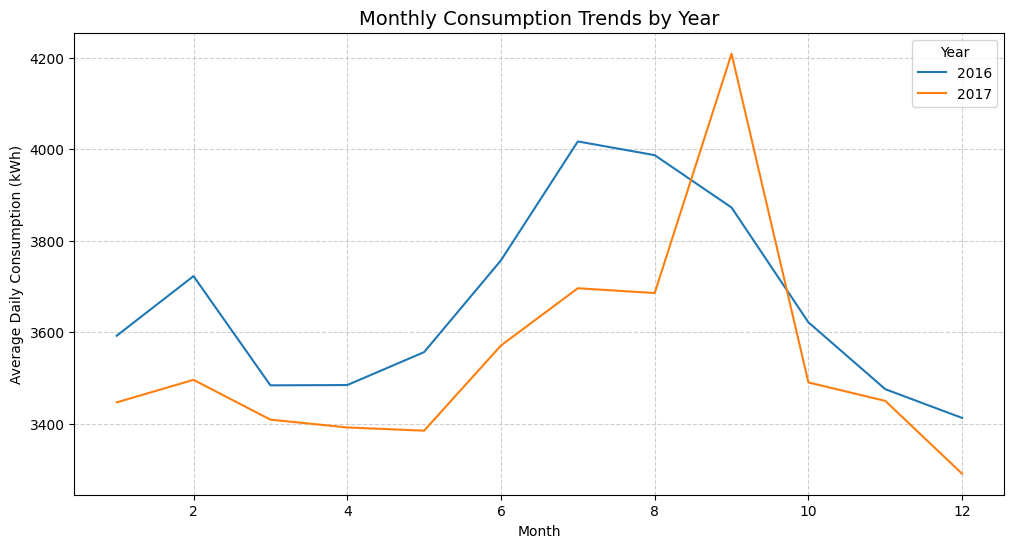

In [12]:
# Year-month trend (to see seasonality over years)
monthly_trend = df.groupby(["year","month"])["daily_consumption"].mean().unstack(level=0)

monthly_trend.plot(figsize=(12,6))
plt.title("Monthly Consumption Trends by Year", fontsize=14)
plt.xlabel("Month")
plt.ylabel("Average Daily Consumption (kWh)")
plt.legend(title="Year")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

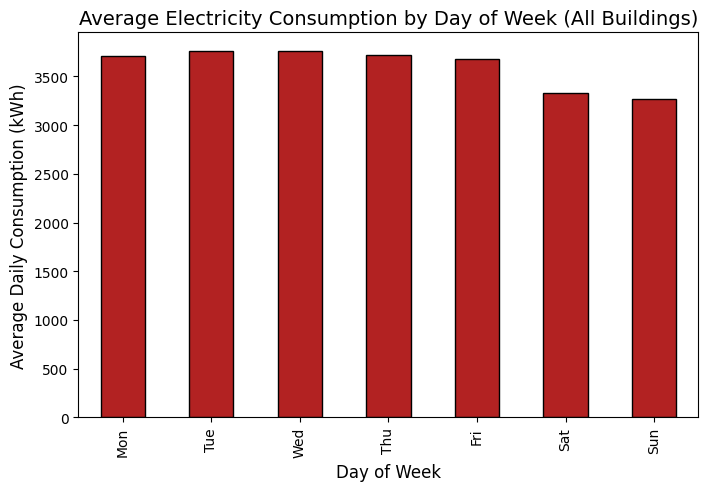

In [13]:
# Extract day of week (0 = Monday, 6 = Sunday)
df['day_of_week'] = df['date'].dt.dayofweek
day_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

# Average daily consumption by day of week
dow_consumption = (
    df.groupby('day_of_week')['daily_consumption']
    .mean()
    .reindex(range(7))
)

# Plot
plt.figure(figsize=(8,5))
dow_consumption.plot(kind='bar', color='firebrick', edgecolor='black')
plt.xticks(range(7), day_labels)
plt.title("Average Electricity Consumption by Day of Week (All Buildings)", fontsize=14)
plt.ylabel("Average Daily Consumption (kWh)", fontsize=12)
plt.xlabel("Day of Week", fontsize=12)
plt.show()

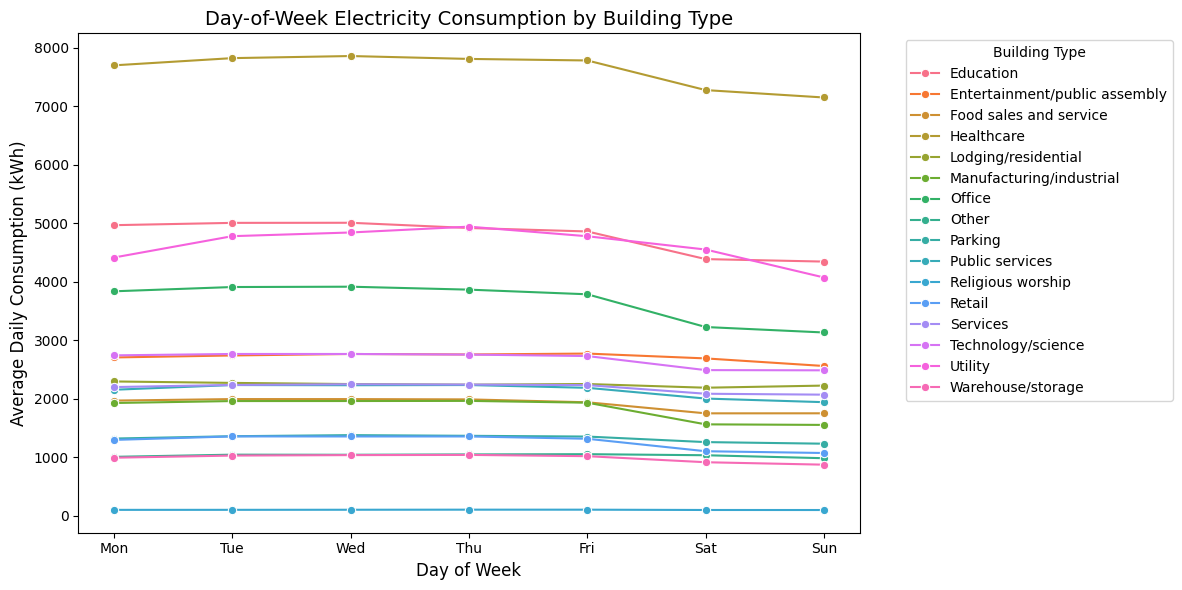

In [14]:
# Compute average daily consumption by building type and day of week
dow_by_type = (
    df.groupby(['primaryspaceusage', 'day_of_week'])['daily_consumption']
    .mean()
    .reset_index()
)

# Map day numbers to labels
day_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
dow_by_type['day_of_week'] = dow_by_type['day_of_week'].map(lambda x: day_labels[x])

# Plot with seaborn
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=dow_by_type,
    x='day_of_week',
    y='daily_consumption',
    hue='primaryspaceusage',
    marker="o"
)

plt.title("Day-of-Week Electricity Consumption by Building Type", fontsize=14)
plt.xlabel("Day of Week", fontsize=12)
plt.ylabel("Average Daily Consumption (kWh)", fontsize=12)
plt.legend(title="Building Type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

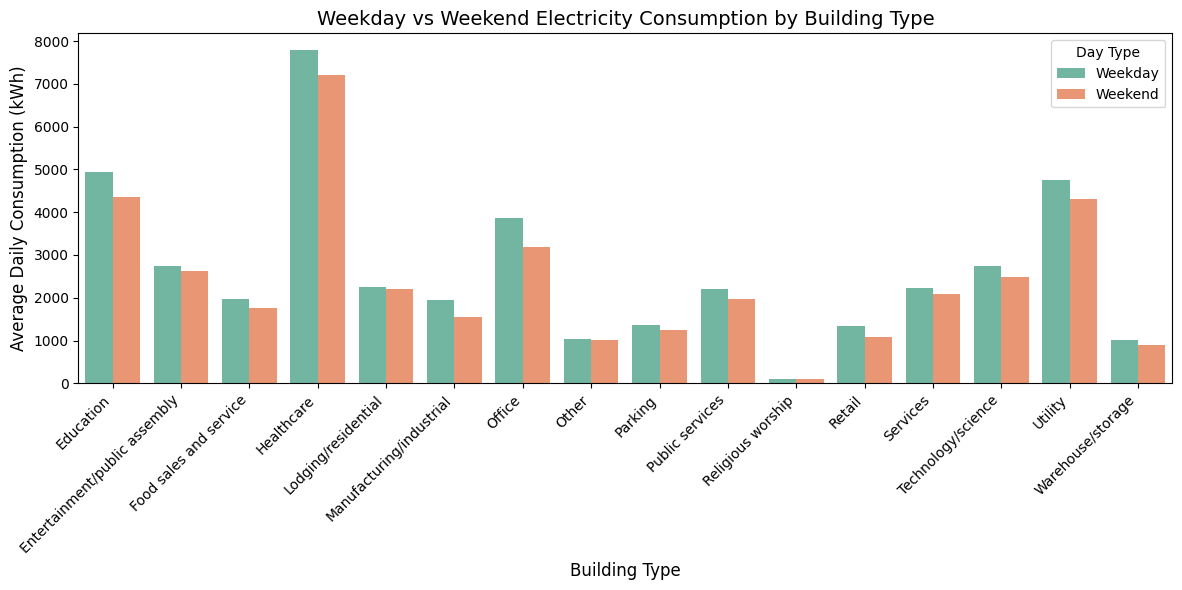

In [15]:
# Create a weekday/weekend flag
df['is_weekend'] = df['date'].dt.dayofweek >= 5  # Sat=5, Sun=6

# Group by building type and weekend/weekday
weekday_vs_weekend = (
    df.groupby(['primaryspaceusage', 'is_weekend'])['daily_consumption']
    .mean()
    .reset_index()
)

# Replace True/False with labels
weekday_vs_weekend['is_weekend'] = weekday_vs_weekend['is_weekend'].map({False: 'Weekday', True: 'Weekend'})

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(
    data=weekday_vs_weekend,
    x='primaryspaceusage',
    y='daily_consumption',
    hue='is_weekend',
    palette='Set2'
)

plt.title("Weekday vs Weekend Electricity Consumption by Building Type", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.xlabel("Building Type", fontsize=12)
plt.ylabel("Average Daily Consumption (kWh)", fontsize=12)
plt.legend(title="Day Type")
plt.tight_layout()
plt.show()

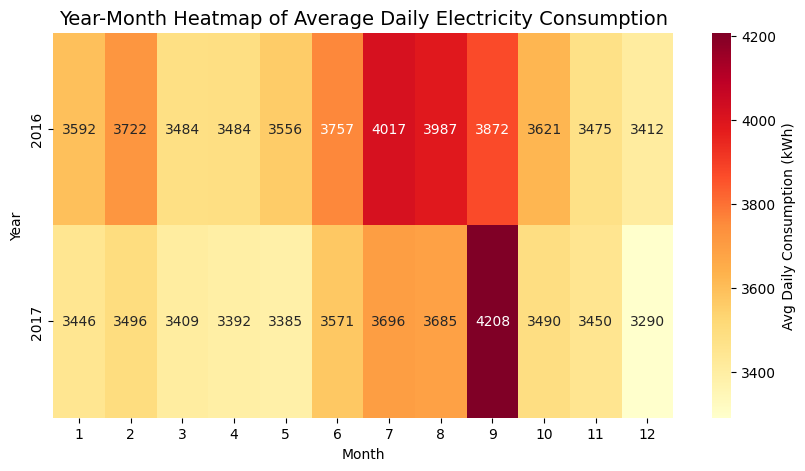

In [16]:
# Final year - month heatmap which gives seasonal+yearly variation all in one plot
# Group by year and month
year_month_avg = (
    df.groupby(['year', 'month'])['daily_consumption']
    .mean()
    .reset_index()
)

# Pivot for heatmap (rows = year, columns = month)
heatmap_data = year_month_avg.pivot(index='year', columns='month', values='daily_consumption')

# Plot
plt.figure(figsize=(10, 5))
sns.heatmap(
    heatmap_data, 
    annot=True, 
    fmt=".0f", 
    cmap="YlOrRd", 
    cbar_kws={'label': 'Avg Daily Consumption (kWh)'}
)
plt.title("Year-Month Heatmap of Average Daily Electricity Consumption", fontsize=14)
plt.xlabel("Month")
plt.ylabel("Year")
plt.show()

<font size="6">Univariate EDA</font>

In [17]:
df.head()

date            building_id  daily_consumption site_id    sqft  \
0 2016-01-01  Robin_public_Carolina           2183.750   Robin  118231   
1 2016-01-02  Robin_public_Carolina           2205.563   Robin  118231   
2 2016-01-03  Robin_public_Carolina           2108.750   Robin  118231   
3 2016-01-04  Robin_public_Carolina           3536.562   Robin  118231   
4 2016-01-05  Robin_public_Carolina           3771.376   Robin  118231   

       sqm       timezone sub_primaryspaceusage primaryspaceusage       lat  \
0  10984.0  Europe/London               Library   Public services  51.51879   
1  10984.0  Europe/London               Library   Public services  51.51879   
2  10984.0  Europe/London               Library   Public services  51.51879   
3  10984.0  Europe/London               Library   Public services  51.51879   
4  10984.0  Europe/London               Library   Public services  51.51879   

   ...  airTemperature  dewTemperature  seaLvlPressure  windDirection  \
0  ...        5.387500        3.879167     1016.941667     116.666667   
1  ...        9.783333        9.183333      998.087500     166.666667   
2  ...        7.954167        6.687500      991.837500     187.916667   
3  ...        7.841667        6.508333      982.766667     177.083333   
4  ...        7.904167        7.058333      984.712500     175.416667   

   windSpeed  is_outlier  month  year  day_of_week  is_weekend  
0   4.470833       False      1  2016            4       False  
1   7.241667       False      1  2016            5        True  
2   5.633333       False      1  2016            6        True  
3   4.145833       False      1  2016            0       False  
4   2.750000       False      1  2016            1       False  

[5 rows x 22 columns]

Daily Consumption

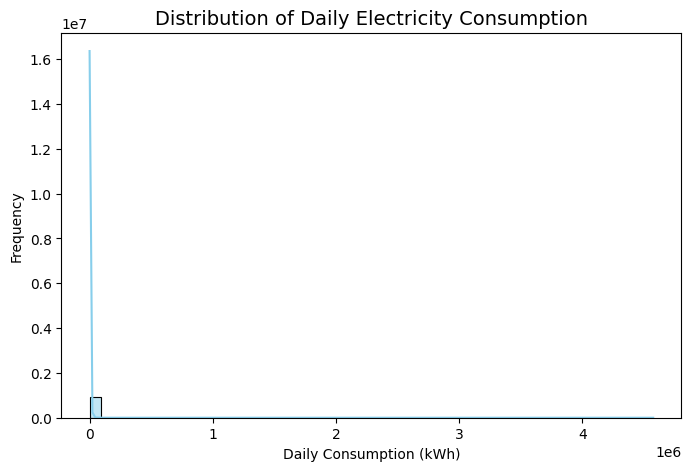

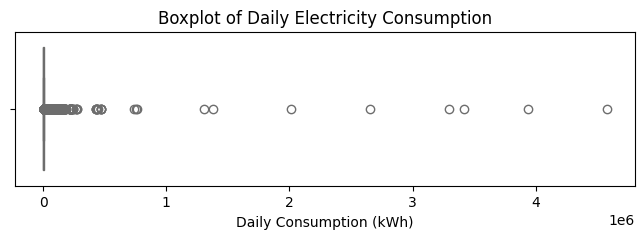

Summary Statistics for Daily Consumption:
count    9.181360e+05
mean     3.603648e+03
std      1.123524e+04
min      2.400000e-03
25%      4.944575e+02
50%      1.506945e+03
75%      3.848711e+03
95%      1.411381e+04
99%      3.011733e+04
max      4.576159e+06
Name: daily_consumption, dtype: float64

Skewness: 205.31
Kurtosis: 68571.58


In [19]:
# --- 1. Histogram + KDE ---
plt.figure(figsize=(8,5))
sns.histplot(df['daily_consumption'], bins=50, kde=True, color="skyblue")
plt.title("Distribution of Daily Electricity Consumption", fontsize=14)
plt.xlabel("Daily Consumption (kWh)")
plt.ylabel("Frequency")
plt.show()

# --- 2. Boxplot ---
plt.figure(figsize=(8,2))
sns.boxplot(x=df['daily_consumption'], color="salmon")
plt.title("Boxplot of Daily Electricity Consumption")
plt.xlabel("Daily Consumption (kWh)")
plt.show()

# --- 3. Summary statistics ---
desc_stats = df['daily_consumption'].describe(percentiles=[0.25,0.5,0.75,0.95,0.99])
skewness = df['daily_consumption'].skew()
kurtosis = df['daily_consumption'].kurt()

print("Summary Statistics for Daily Consumption:")
print(desc_stats)
print(f"\nSkewness: {skewness:.2f}")
print(f"Kurtosis: {kurtosis:.2f}")

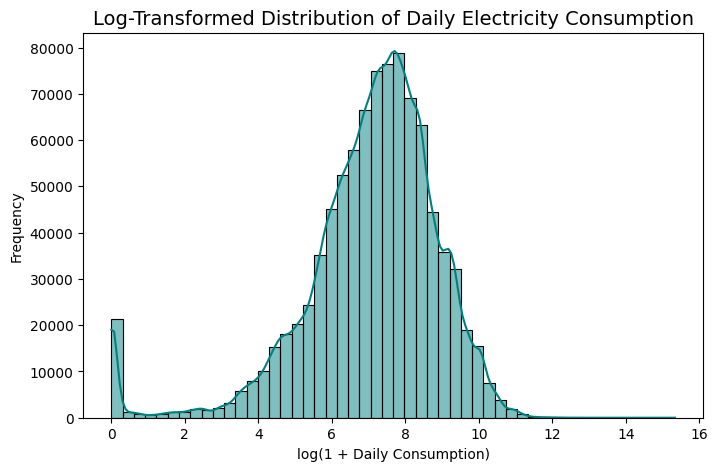

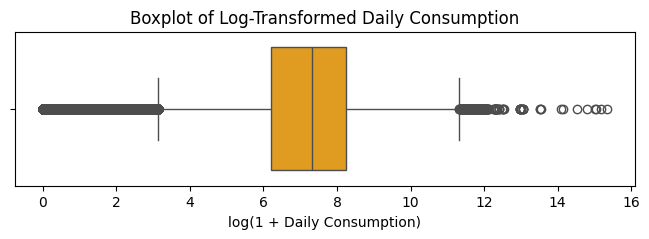

Summary Statistics for log_Daily Consumption:
count    918136.000000
mean          7.054707
std           1.892668
min           0.002397
25%           6.205482
50%           7.318503
75%           8.255753
95%           9.554980
99%          10.312889
max          15.336371
Name: log_daily_consumption, dtype: float64

Skewness: -1.35
Kurtosis: 3.13


In [20]:
# Add a log-transformed column (avoid log(0) by adding a small epsilon)
df['log_daily_consumption'] = np.log1p(df['daily_consumption'])

# Plot histogram + KDE for log-transformed values
plt.figure(figsize=(8,5))
sns.histplot(df['log_daily_consumption'], bins=50, kde=True, color="teal")
plt.title("Log-Transformed Distribution of Daily Electricity Consumption", fontsize=14)
plt.xlabel("log(1 + Daily Consumption)")
plt.ylabel("Frequency")
plt.show()

# Boxplot for log-transformed values
plt.figure(figsize=(8,2))
sns.boxplot(x=df['log_daily_consumption'], color="orange")
plt.title("Boxplot of Log-Transformed Daily Consumption")
plt.xlabel("log(1 + Daily Consumption)")
plt.show()

# --- 3. Summary statistics ---
desc_stats = df['log_daily_consumption'].describe(percentiles=[0.25,0.5,0.75,0.95,0.99])
skewness = df['log_daily_consumption'].skew()
kurtosis = df['log_daily_consumption'].kurt()

print("Summary Statistics for log_Daily Consumption:")
print(desc_stats)
print(f"\nSkewness: {skewness:.2f}")
print(f"Kurtosis: {kurtosis:.2f}")

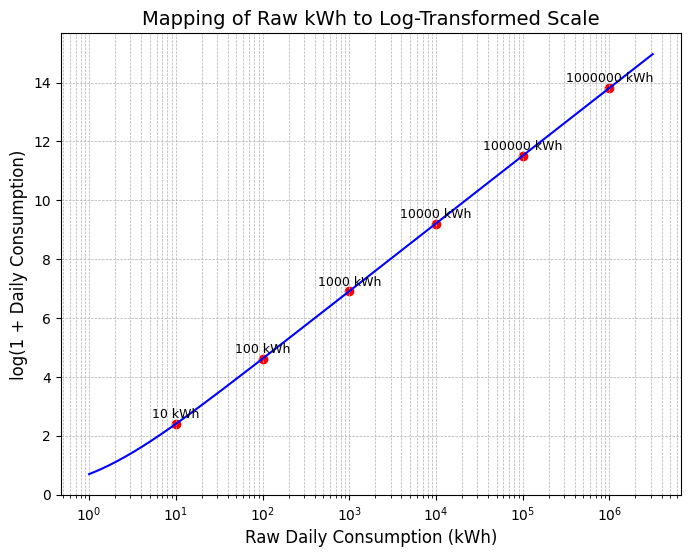

In [21]:
# Generate a range of raw daily consumption values (log-spaced for coverage)
raw_values = np.logspace(0, 6.5, num=200)  # from 1 kWh to ~3,000,000 kWh
log_values = np.log1p(raw_values)

# Plot
plt.figure(figsize=(8,6))
plt.plot(raw_values, log_values, color="blue")
plt.xscale("log")  # log scale on x-axis to spread values
plt.xlabel("Raw Daily Consumption (kWh)", fontsize=12)
plt.ylabel("log(1 + Daily Consumption)", fontsize=12)
plt.title("Mapping of Raw kWh to Log-Transformed Scale", fontsize=14)

# Add reference markers
for val in [10, 100, 1000, 10000, 100000, 1000000]:
    plt.scatter(val, np.log1p(val), color="red")
    plt.text(val, np.log1p(val)+0.2, f"{val} kWh", ha="center", fontsize=9)

plt.grid(True, which="both", ls="--", lw=0.5)
plt.show()

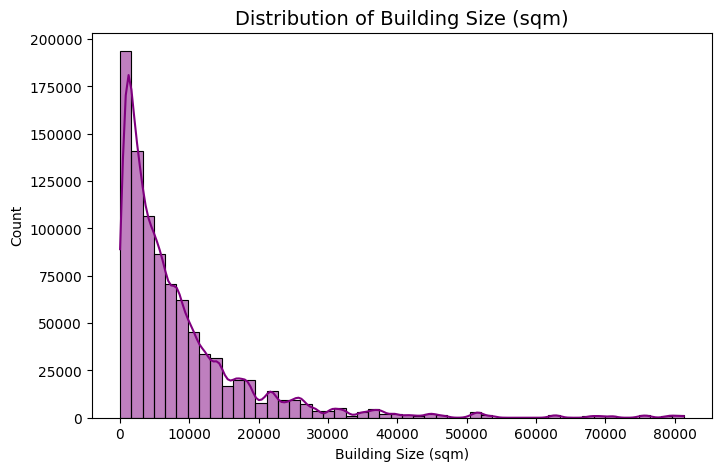

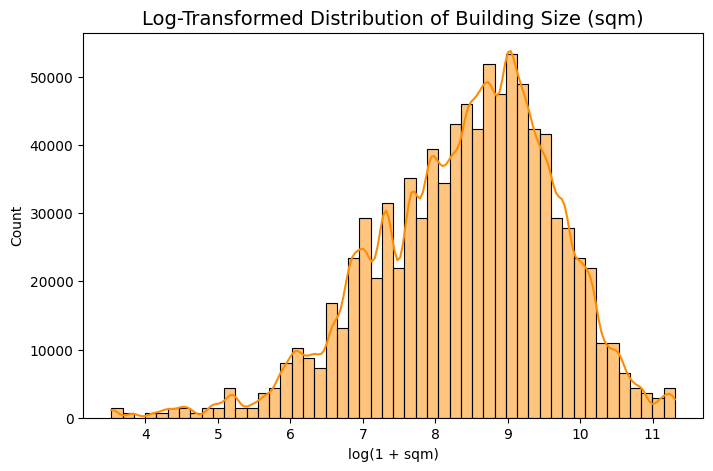

Summary Statistics for Building Size (sqm):
count    918136.000000
mean       8498.805971
std       10333.148602
min          33.100000
25%        2071.800000
50%        5293.800000
75%       10789.500000
95%       26718.300000
99%       51767.100000
max       81290.100000
Name: sqm, dtype: float64

Skewness: 3.07
Kurtosis: 13.30


In [22]:
# --- 1. Raw histogram ---
plt.figure(figsize=(8,5))
sns.histplot(df['sqm'], bins=50, kde=True, color="purple")
plt.title("Distribution of Building Size (sqm)", fontsize=14)
plt.xlabel("Building Size (sqm)")
plt.ylabel("Count")
plt.show()

# --- 2. Log-transformed histogram ---
df['log_sqm'] = np.log1p(df['sqm'])

plt.figure(figsize=(8,5))
sns.histplot(df['log_sqm'], bins=50, kde=True, color="darkorange")
plt.title("Log-Transformed Distribution of Building Size (sqm)", fontsize=14)
plt.xlabel("log(1 + sqm)")
plt.ylabel("Count")
plt.show()

# --- 3. Summary statistics ---
desc_stats_sqm = df['sqm'].describe(percentiles=[0.25,0.5,0.75,0.95,0.99])
skewness_sqm = df['sqm'].skew()
kurtosis_sqm = df['sqm'].kurt()

print("Summary Statistics for Building Size (sqm):")
print(desc_stats_sqm)
print(f"\nSkewness: {skewness_sqm:.2f}")
print(f"Kurtosis: {kurtosis_sqm:.2f}")


In [23]:
# --- Summary statistics for log transform---
desc_stats_sqm = df['log_sqm'].describe(percentiles=[0.25,0.5,0.75,0.95,0.99])
skewness_sqm = df['log_sqm'].skew()
kurtosis_sqm = df['log_sqm'].kurt()

print("Summary Statistics for log transformed Building Size (sqm):")
print(desc_stats_sqm)
print(f"\nSkewness: {skewness_sqm:.2f}")
print(f"Kurtosis: {kurtosis_sqm:.2f}")

Summary Statistics for log transformed Building Size (sqm):
count    918136.000000
mean          8.417764
std           1.239557
min           3.529297
25%           7.636652
50%           8.574480
75%           9.286421
95%          10.193141
99%          10.854529
max          11.305792
Name: log_sqm, dtype: float64

Skewness: -0.55
Kurtosis: 0.44


In [ ]:
# Save Intermediate dataset
df.to_parquet("intermediate_set.parquet", engine="fastparquet", index=False)
print(" Saved intermediate_set.parquet")

In [3]:
# Load intermediate dataset
df = pd.read_parquet("intermediate_set.parquet", engine="fastparquet")

In [4]:
df.head()

date            building_id  daily_consumption site_id    sqft  \
0 2016-01-01  Robin_public_Carolina           2183.750   Robin  118231   
1 2016-01-02  Robin_public_Carolina           2205.563   Robin  118231   
2 2016-01-03  Robin_public_Carolina           2108.750   Robin  118231   
3 2016-01-04  Robin_public_Carolina           3536.562   Robin  118231   
4 2016-01-05  Robin_public_Carolina           3771.376   Robin  118231   

       sqm       timezone sub_primaryspaceusage primaryspaceusage       lat  \
0  10984.0  Europe/London               Library   Public services  51.51879   
1  10984.0  Europe/London               Library   Public services  51.51879   
2  10984.0  Europe/London               Library   Public services  51.51879   
3  10984.0  Europe/London               Library   Public services  51.51879   
4  10984.0  Europe/London               Library   Public services  51.51879   

   ...  seaLvlPressure  windDirection  windSpeed  is_outlier  month  year  \
0  ...     1016.941667     116.666667   4.470833       False      1  2016   
1  ...      998.087500     166.666667   7.241667       False      1  2016   
2  ...      991.837500     187.916667   5.633333       False      1  2016   
3  ...      982.766667     177.083333   4.145833       False      1  2016   
4  ...      984.712500     175.416667   2.750000       False      1  2016   

   day_of_week  is_weekend  log_daily_consumption   log_sqm  
0            4       False               7.689257  9.304286  
1            5        True               7.699191  9.304286  
2            6        True               7.654325  9.304286  
3            0       False               8.171193  9.304286  
4            1       False               8.235460  9.304286  

[5 rows x 24 columns]

/tmp/ipykernel_5375/404070251.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


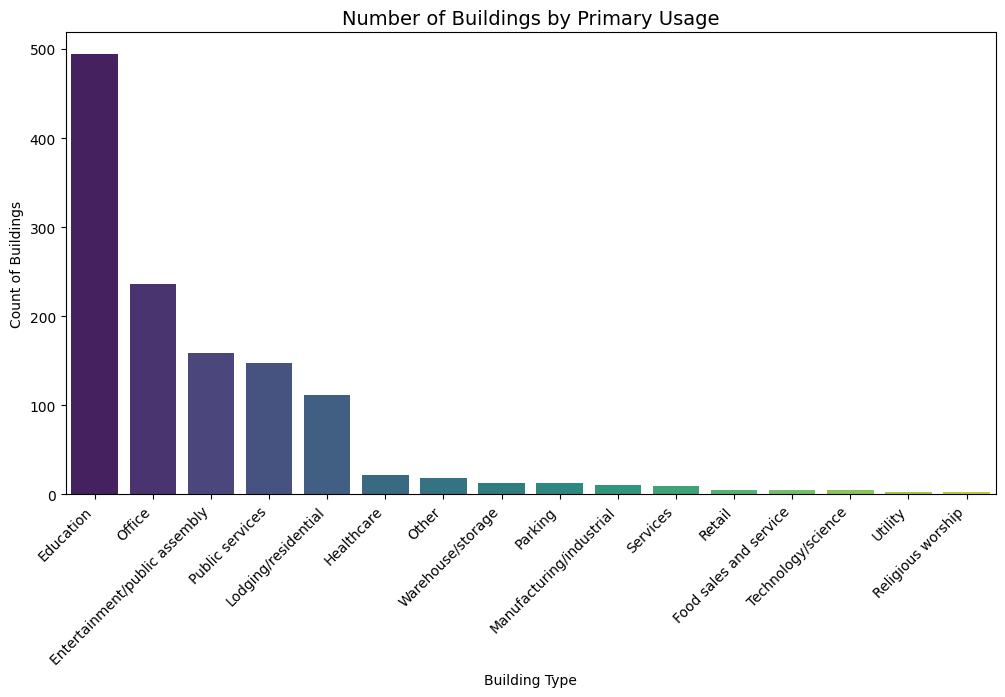

Building counts by type:
 primaryspaceusage
Education                        494
Office                           236
Entertainment/public assembly    159
Public services                  148
Lodging/residential              112
Healthcare                        22
Other                             18
Warehouse/storage                 13
Parking                           13
Manufacturing/industrial          11
Services                           9
Retail                             5
Food sales and service             5
Technology/science                 5
Utility                            3
Religious worship                  3
Name: count, dtype: int64


In [4]:
# This is to count how many buildings there are per category
plt.figure(figsize=(12,6))
sns.countplot(
    data=df.drop_duplicates('building_id'),  # ensure each building counted once
    x='primaryspaceusage',
    order=df.drop_duplicates('building_id')['primaryspaceusage'].value_counts().index,
    palette="viridis"
)
plt.xticks(rotation=45, ha='right')
plt.title("Number of Buildings by Primary Usage", fontsize=14)
plt.xlabel("Building Type")
plt.ylabel("Count of Buildings")
plt.show()

# Print counts for reference
building_type_counts = df.drop_duplicates('building_id')['primaryspaceusage'].value_counts()
print("Building counts by type:\n", building_type_counts)

/tmp/ipykernel_5375/1440833697.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_consumption_by_type.index, y=avg_consumption_by_type.values, palette="viridis")


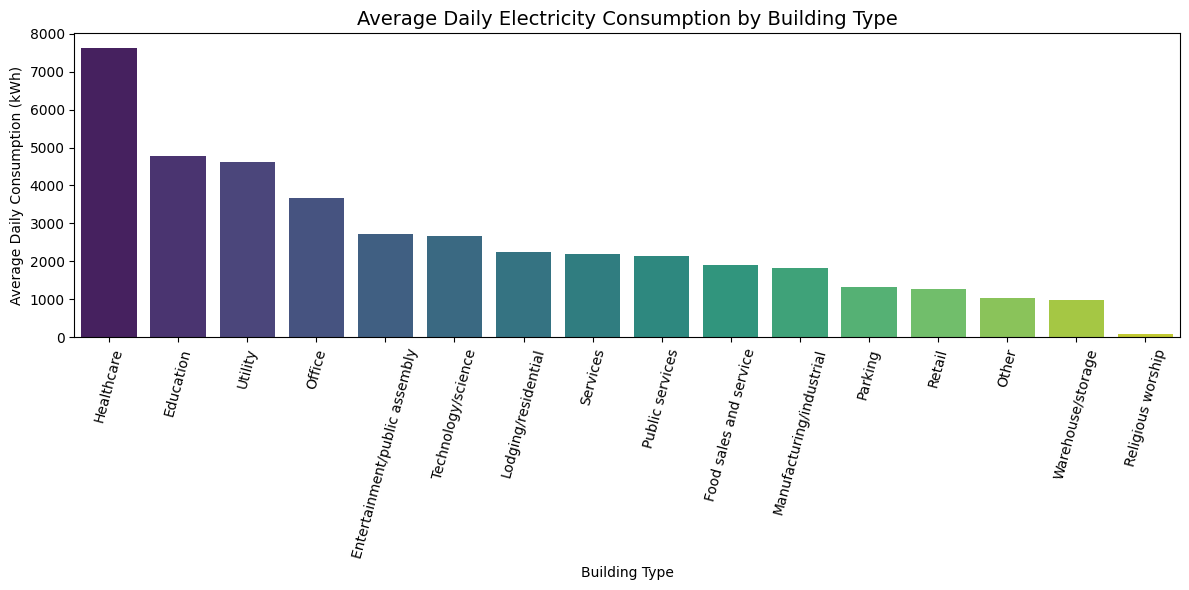

In [5]:
# Compute average daily consumption by building type
avg_consumption_by_type = df.groupby("primaryspaceusage")["daily_consumption"].mean().sort_values(ascending=False)

# Plot
plt.figure(figsize=(12,6))
sns.barplot(x=avg_consumption_by_type.index, y=avg_consumption_by_type.values, palette="viridis")

plt.xticks(rotation=75)
plt.title("Average Daily Electricity Consumption by Building Type", fontsize=14)
plt.ylabel("Average Daily Consumption (kWh)")
plt.xlabel("Building Type")
plt.tight_layout()
plt.show()

In [6]:
avg_consumption_by_type 

primaryspaceusage
Healthcare                       7623.368651
Education                        4781.557279
Utility                          4622.926027
Office                           3664.973109
Entertainment/public assembly    2712.092566
Technology/science               2675.172140
Lodging/residential              2245.942161
Services                         2187.385900
Public services                  2140.224602
Food sales and service           1912.063066
Manufacturing/industrial         1836.571449
Parking                          1324.229639
Retail                           1265.006598
Other                            1030.856349
Warehouse/storage                 986.641642
Religious worship                 102.430818
Name: daily_consumption, dtype: float64

/tmp/ipykernel_5375/4155485316.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_consumption_median_by_type.index, y=avg_consumption_median_by_type.values, palette="viridis")


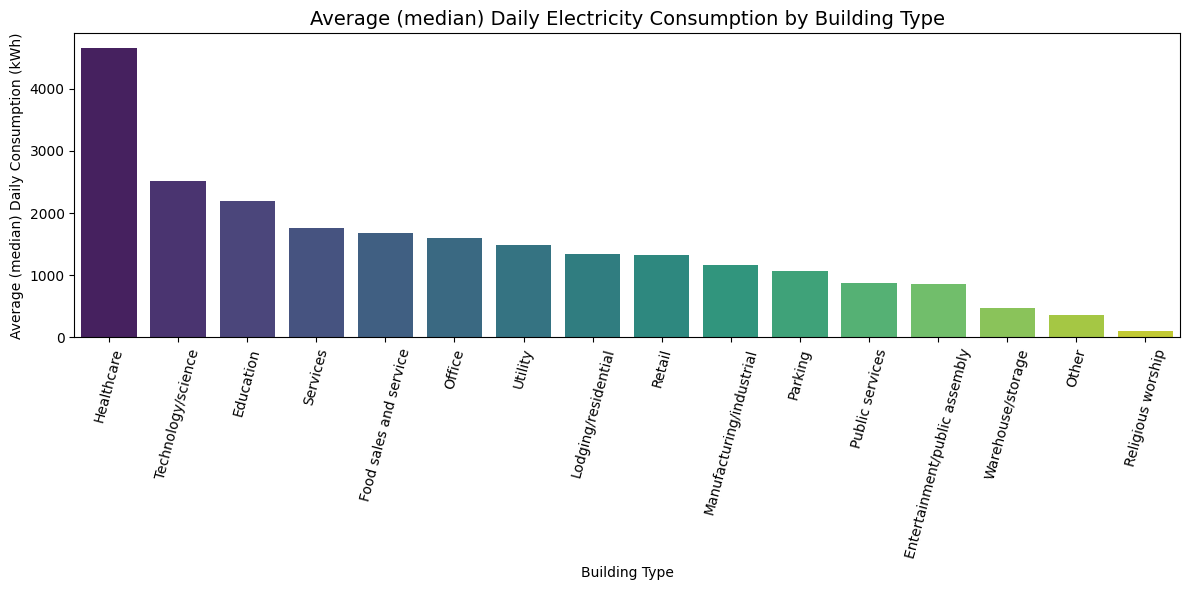

In [7]:
# Compute average daily consumption by building type (Median values)
avg_consumption_median_by_type = df.groupby("primaryspaceusage")["daily_consumption"].median().sort_values(ascending=False)

# Plot
plt.figure(figsize=(12,6))
sns.barplot(x=avg_consumption_median_by_type.index, y=avg_consumption_median_by_type.values, palette="viridis")

plt.xticks(rotation=75)
plt.title("Average (median) Daily Electricity Consumption by Building Type", fontsize=14)
plt.ylabel("Average (median) Daily Consumption (kWh)")
plt.xlabel("Building Type")
plt.tight_layout()
plt.show()

In [8]:
avg_consumption_median_by_type

primaryspaceusage
Healthcare                       4659.31720
Technology/science               2514.52000
Education                        2196.13500
Services                         1757.13400
Food sales and service           1685.77000
Office                           1601.93715
Utility                          1480.82500
Lodging/residential              1336.59750
Retail                           1323.27000
Manufacturing/industrial         1172.30000
Parking                          1066.23100
Public services                   881.35500
Entertainment/public assembly     861.75000
Warehouse/storage                 478.60000
Other                             363.31500
Religious worship                 102.59000
Name: daily_consumption, dtype: float64

/tmp/ipykernel_5375/2433929760.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


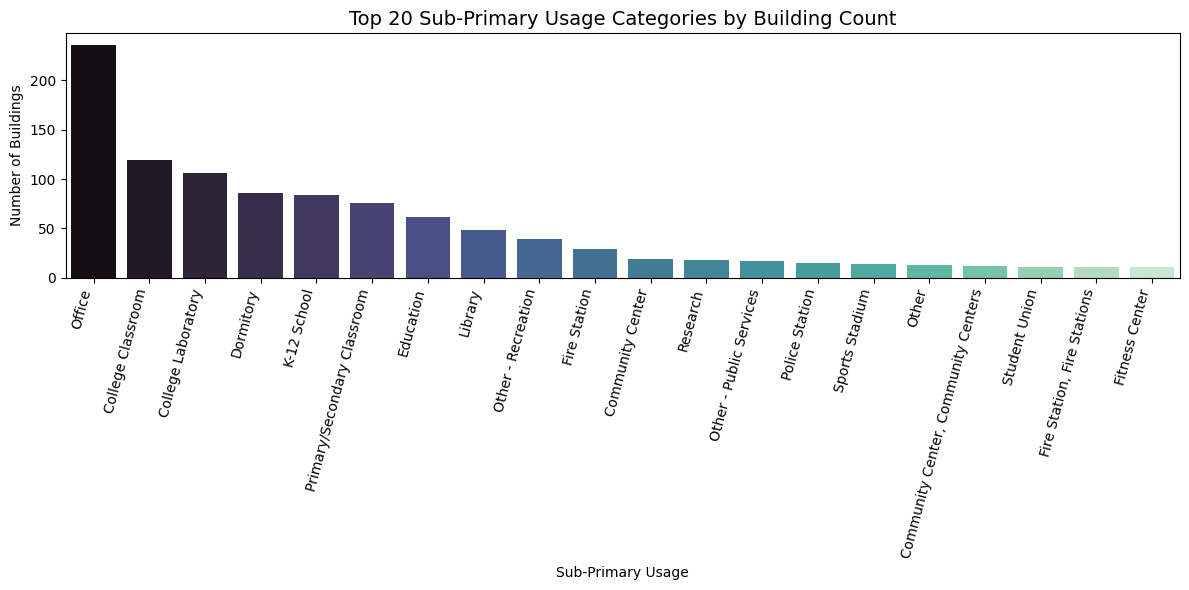

In [10]:
# Analysis of subsub-primary usage
# Count unique sub-primary usage categories
sub_counts = df.drop_duplicates("building_id")["sub_primaryspaceusage"].value_counts()

# Plot top categories only for clarity
plt.figure(figsize=(12,6))
sns.barplot(
    x=sub_counts.head(20).index, 
    y=sub_counts.head(20).values, 
    palette="mako"
)
plt.xticks(rotation=75, ha='right')
plt.title("Top 20 Sub-Primary Usage Categories by Building Count", fontsize=14)
plt.ylabel("Number of Buildings")
plt.xlabel("Sub-Primary Usage")
plt.tight_layout()
plt.show()

In [15]:
# convert to string to output all values 
print(sub_counts.to_string())

sub_primaryspaceusage
Office                                               236
College Classroom                                    119
College Laboratory                                   106
Dormitory                                             86
K-12 School                                           84
Primary/Secondary Classroom                           76
Education                                             62
Library                                               48
Other - Recreation                                    39
Fire Station                                          29
Community Center                                      19
Research                                              18
Other - Public Services                               17
Police Station                                        15
Sports Stadium                                        14
Other                                                 13
Community Center, Community Centers                   12
Student U

/tmp/ipykernel_4193/2612237849.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


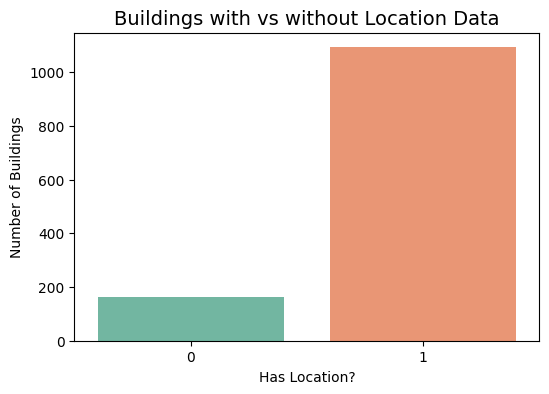

Counts:
 has_location
1    1093
0     163
Name: count, dtype: int64

Percentages:
 has_location
1    87.02
0    12.98
Name: proportion, dtype: float64


In [4]:
plt.figure(figsize=(6,4))
sns.countplot(
    data=df.drop_duplicates("building_id"),
    x="has_location",
    palette="Set2"
)
plt.title("Buildings with vs without Location Data", fontsize=14)
plt.xlabel("Has Location?")
plt.ylabel("Number of Buildings")
plt.show()

# Print counts and percentages
location_counts = df.drop_duplicates("building_id")["has_location"].value_counts()
location_percent = df.drop_duplicates("building_id")["has_location"].value_counts(normalize=True) * 100

print("Counts:\n", location_counts)
print("\nPercentages:\n", location_percent.round(2))


Summary Statistics for Air Temperature:
count    918006.000000
mean         15.185425
std           9.867760
min         -24.791667
25%           8.637500
50%          15.670833
75%          22.619048
max          40.508333
Name: airTemperature, dtype: float64

Skewness: -0.34
Kurtosis: 0.09


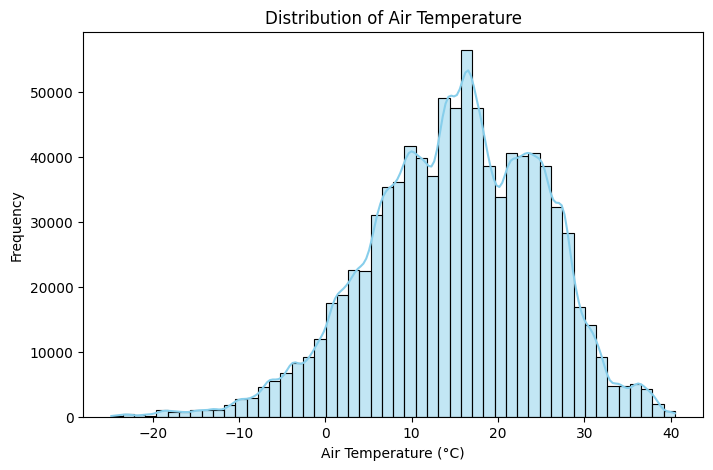

In [5]:
# --- Summary statistics ---
air_temp_stats = df['airTemperature'].describe()
skewness = df['airTemperature'].skew()
kurtosis = df['airTemperature'].kurtosis()

print("Summary Statistics for Air Temperature:")
print(air_temp_stats)
print(f"\nSkewness: {skewness:.2f}")
print(f"Kurtosis: {kurtosis:.2f}")

# --- Histogram + KDE ---
plt.figure(figsize=(8,5))
sns.histplot(df['airTemperature'], bins=50, kde=True, color="skyblue")
plt.title("Distribution of Air Temperature")
plt.xlabel("Air Temperature (°C)")
plt.ylabel("Frequency")
plt.show()

/tmp/ipykernel_4193/2587086962.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="month", y="airTemperature", data=df, palette="coolwarm")


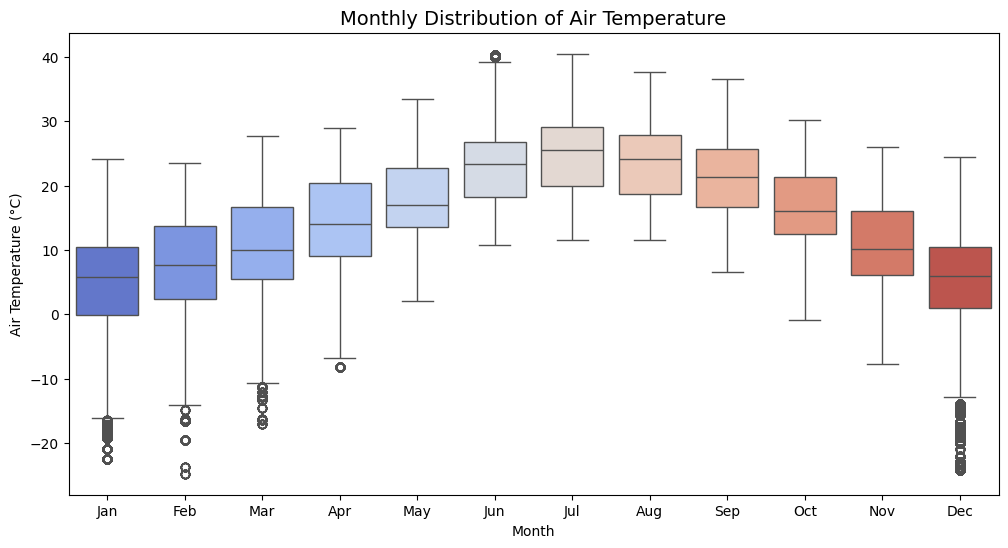

In [6]:
plt.figure(figsize=(12,6))
sns.boxplot(x="month", y="airTemperature", data=df, palette="coolwarm")

plt.title("Monthly Distribution of Air Temperature", fontsize=14)
plt.xlabel("Month")
plt.ylabel("Air Temperature (°C)")
plt.xticks(range(0,12), 
           ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"])
plt.show()

Summary Statistics for Dew Temperature:
count    918006.000000
mean          7.654476
std           9.419877
min         -31.083333
25%           1.304167
50%           8.600000
75%          14.683333
95%          21.800000
99%          23.508333
max          25.175000
Name: dewTemperature, dtype: float64

Skewness: -0.48
Kurtosis: -0.08


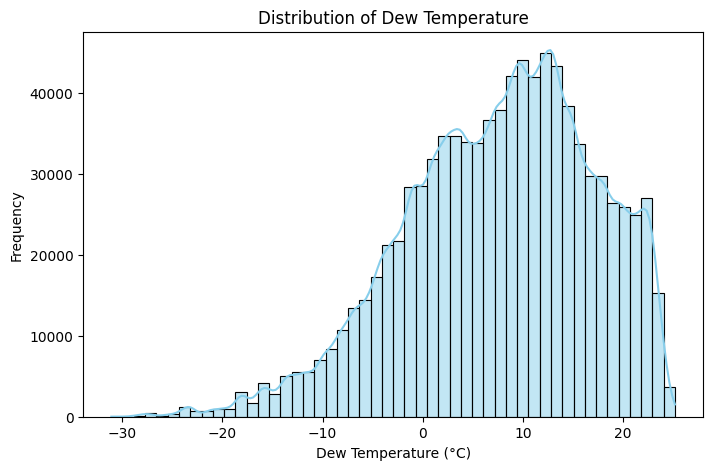

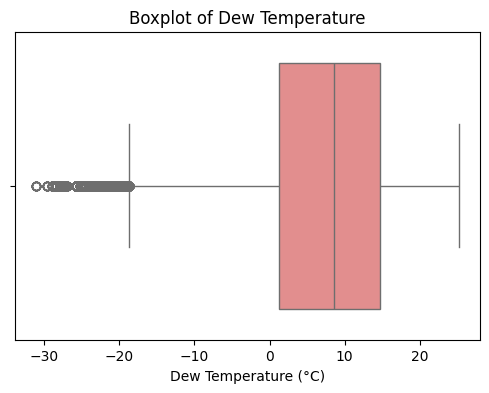

/tmp/ipykernel_4193/3022716111.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df["date"].dt.month, y=df["dewTemperature"], palette="coolwarm")


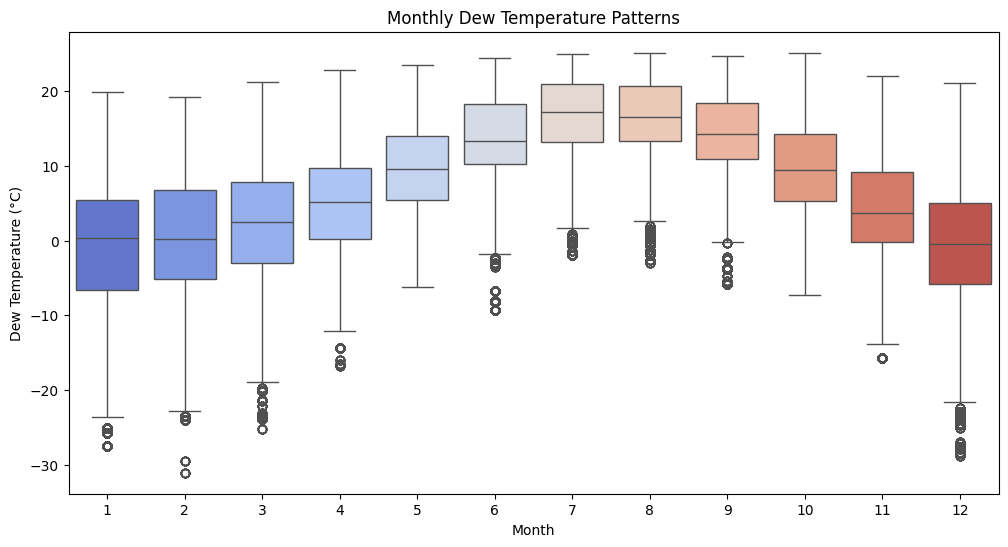

In [7]:
# Analysis of Dew temperature
# Summary stats
dew_stats = df["dewTemperature"].describe(percentiles=[0.25,0.5,0.75,0.95,0.99])
dew_skew = df["dewTemperature"].skew()
dew_kurt = df["dewTemperature"].kurt()

print("Summary Statistics for Dew Temperature:")
print(dew_stats)
print(f"\nSkewness: {dew_skew:.2f}")
print(f"Kurtosis: {dew_kurt:.2f}")

# Histogram + KDE
plt.figure(figsize=(8,5))
sns.histplot(df["dewTemperature"], bins=50, kde=True, color="skyblue")
plt.title("Distribution of Dew Temperature")
plt.xlabel("Dew Temperature (°C)")
plt.ylabel("Frequency")
plt.show()

# Boxplot
plt.figure(figsize=(6,4))
sns.boxplot(x=df["dewTemperature"], color="lightcoral")
plt.title("Boxplot of Dew Temperature")
plt.xlabel("Dew Temperature (°C)")
plt.show()

# Monthly boxplots
plt.figure(figsize=(12,6))
sns.boxplot(x=df["date"].dt.month, y=df["dewTemperature"], palette="coolwarm")
plt.title("Monthly Dew Temperature Patterns")
plt.xlabel("Month")
plt.ylabel("Dew Temperature (°C)")
plt.show()


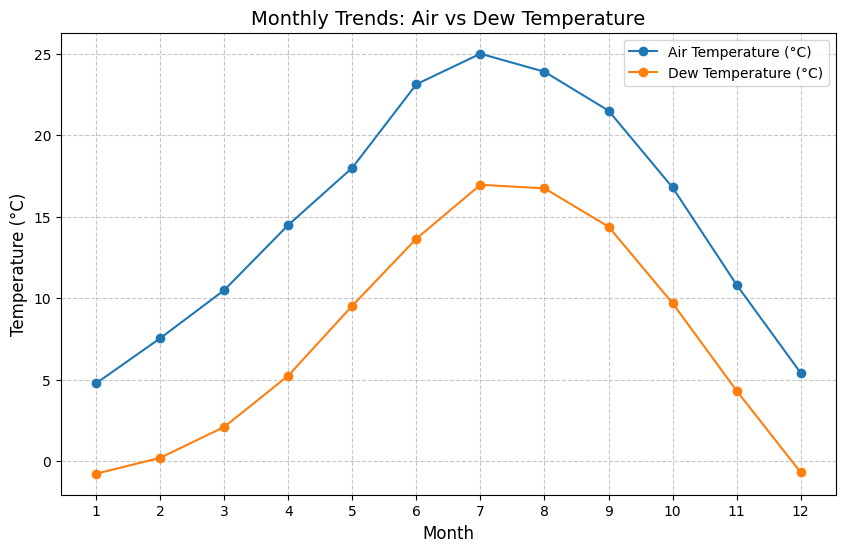

In [8]:
# Comparison of Air and Dew temperature line graph 
# Group by month and take average
monthly_weather = df.groupby(df['date'].dt.month)[['airTemperature', 'dewTemperature']].mean()

# Plot
plt.figure(figsize=(10,6))
plt.plot(monthly_weather.index, monthly_weather['airTemperature'], marker='o', label='Air Temperature (°C)')
plt.plot(monthly_weather.index, monthly_weather['dewTemperature'], marker='o', label='Dew Temperature (°C)')

plt.title("Monthly Trends: Air vs Dew Temperature", fontsize=14)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Temperature (°C)", fontsize=12)
plt.xticks(range(1,13))
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()

Summary Statistics for Wind Speed:
count    918006.000000
mean          3.647099
std           1.683890
min           0.187500
25%           2.433333
50%           3.362500
75%           4.566667
95%           6.825000
99%           8.679167
max          14.416667
Name: windSpeed, dtype: float64

Skewness: 0.9936433494558541
Kurtosis: 1.4107947189952426


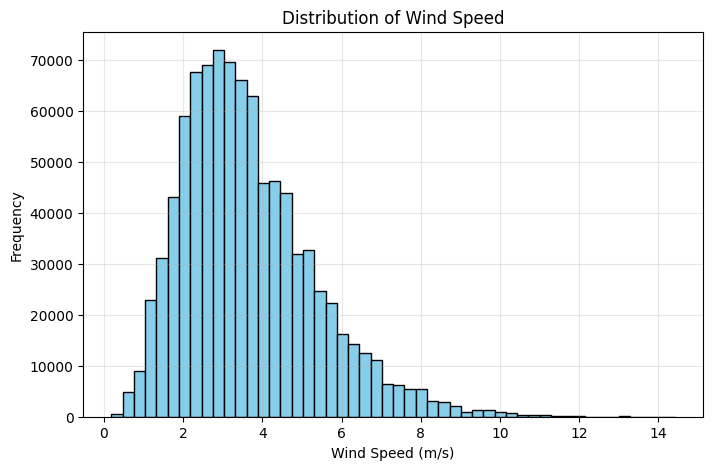

In [9]:
# Summary stats
print("Summary Statistics for Wind Speed:")
print(df['windSpeed'].describe(percentiles=[.25,.5,.75,.95,.99]))

# Skewness & Kurtosis
print("\nSkewness:", df['windSpeed'].skew())
print("Kurtosis:", df['windSpeed'].kurtosis())

# Histogram
plt.figure(figsize=(8,5))
plt.hist(df['windSpeed'], bins=50, color='skyblue', edgecolor='black')
plt.title("Distribution of Wind Speed")
plt.xlabel("Wind Speed (m/s)")
plt.ylabel("Frequency")
plt.grid(True, alpha=0.3)
plt.show()


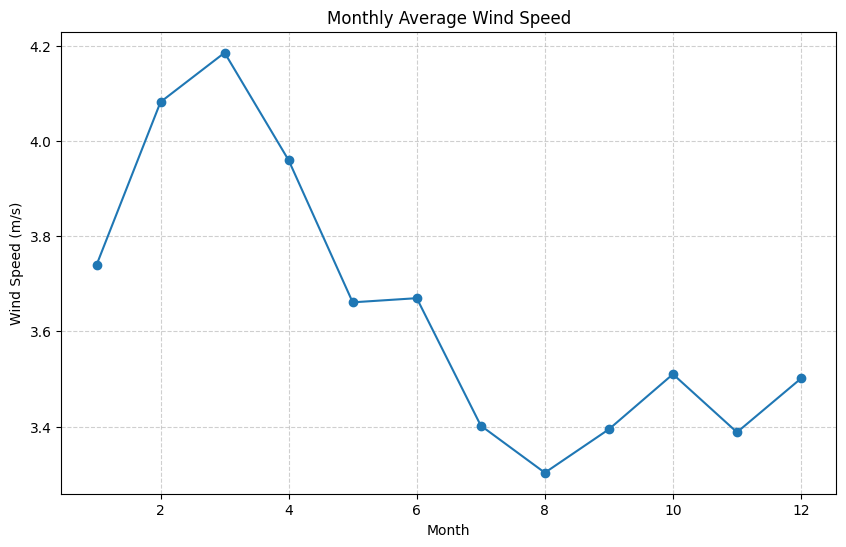

In [10]:
plt.figure(figsize=(10,6))
df.groupby(df['date'].dt.month)['windSpeed'].mean().plot(marker='o')
plt.title("Monthly Average Wind Speed")
plt.xlabel("Month")
plt.ylabel("Wind Speed (m/s)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

/tmp/ipykernel_4287/3258044967.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df['date'].dt.month, y=df['windSpeed'], palette="coolwarm")


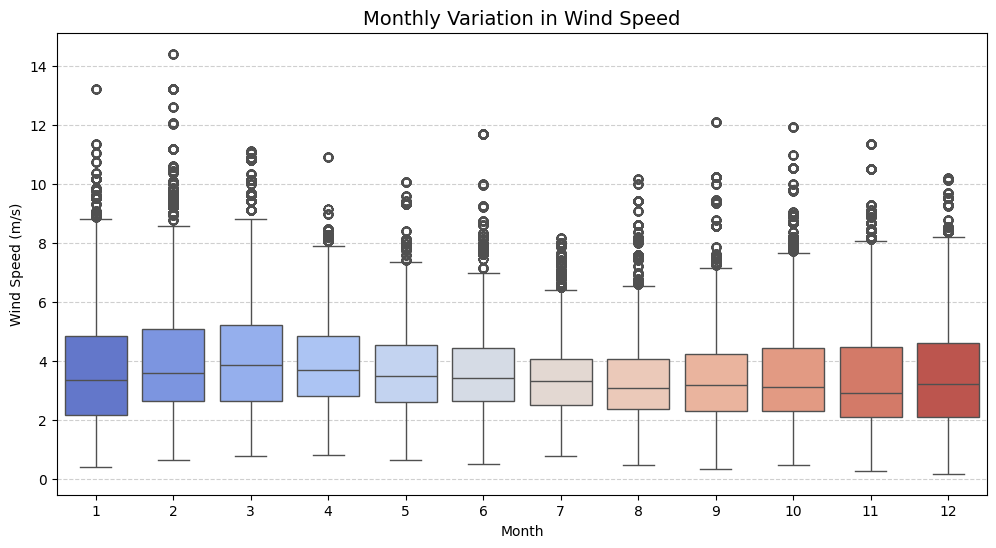

In [5]:
plt.figure(figsize=(12,6))
sns.boxplot(x=df['date'].dt.month, y=df['windSpeed'], palette="coolwarm")

plt.title("Monthly Variation in Wind Speed", fontsize=14)
plt.xlabel("Month")
plt.ylabel("Wind Speed (m/s)")
plt.grid(axis='y', linestyle="--", alpha=0.6)
plt.show()


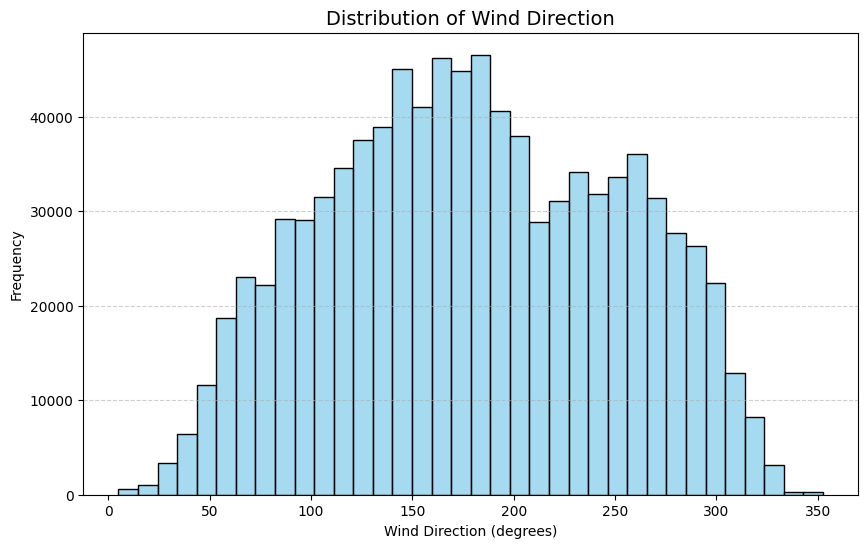

In [6]:
# Histogram of wind direction
plt.figure(figsize=(10,6))
sns.histplot(df['windDirection'], bins=36, kde=False, color="skyblue")
plt.title("Distribution of Wind Direction", fontsize=14)
plt.xlabel("Wind Direction (degrees)")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle="--", alpha=0.6)
plt.show()

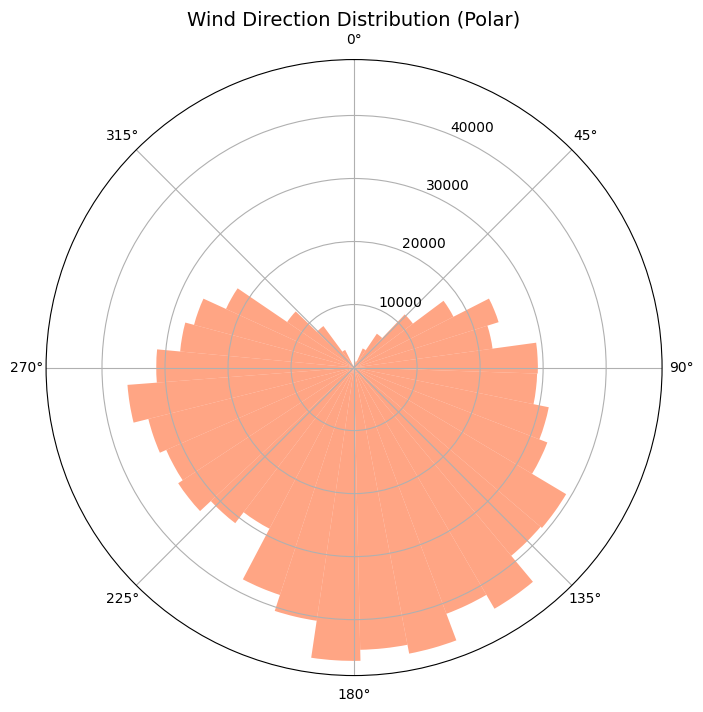

In [8]:
# Polar plot (wind rose style)
plt.figure(figsize=(8,8))
ax = plt.subplot(111, polar=True)
# Convert degrees to radians
theta = np.deg2rad(df['windDirection'].dropna())
ax.hist(theta, bins=36, color="coral", alpha=0.7)
ax.set_theta_zero_location("N")  # 0° at North
ax.set_theta_direction(-1)       # Clockwise
plt.title("Wind Direction Distribution (Polar)", fontsize=14)
plt.show()

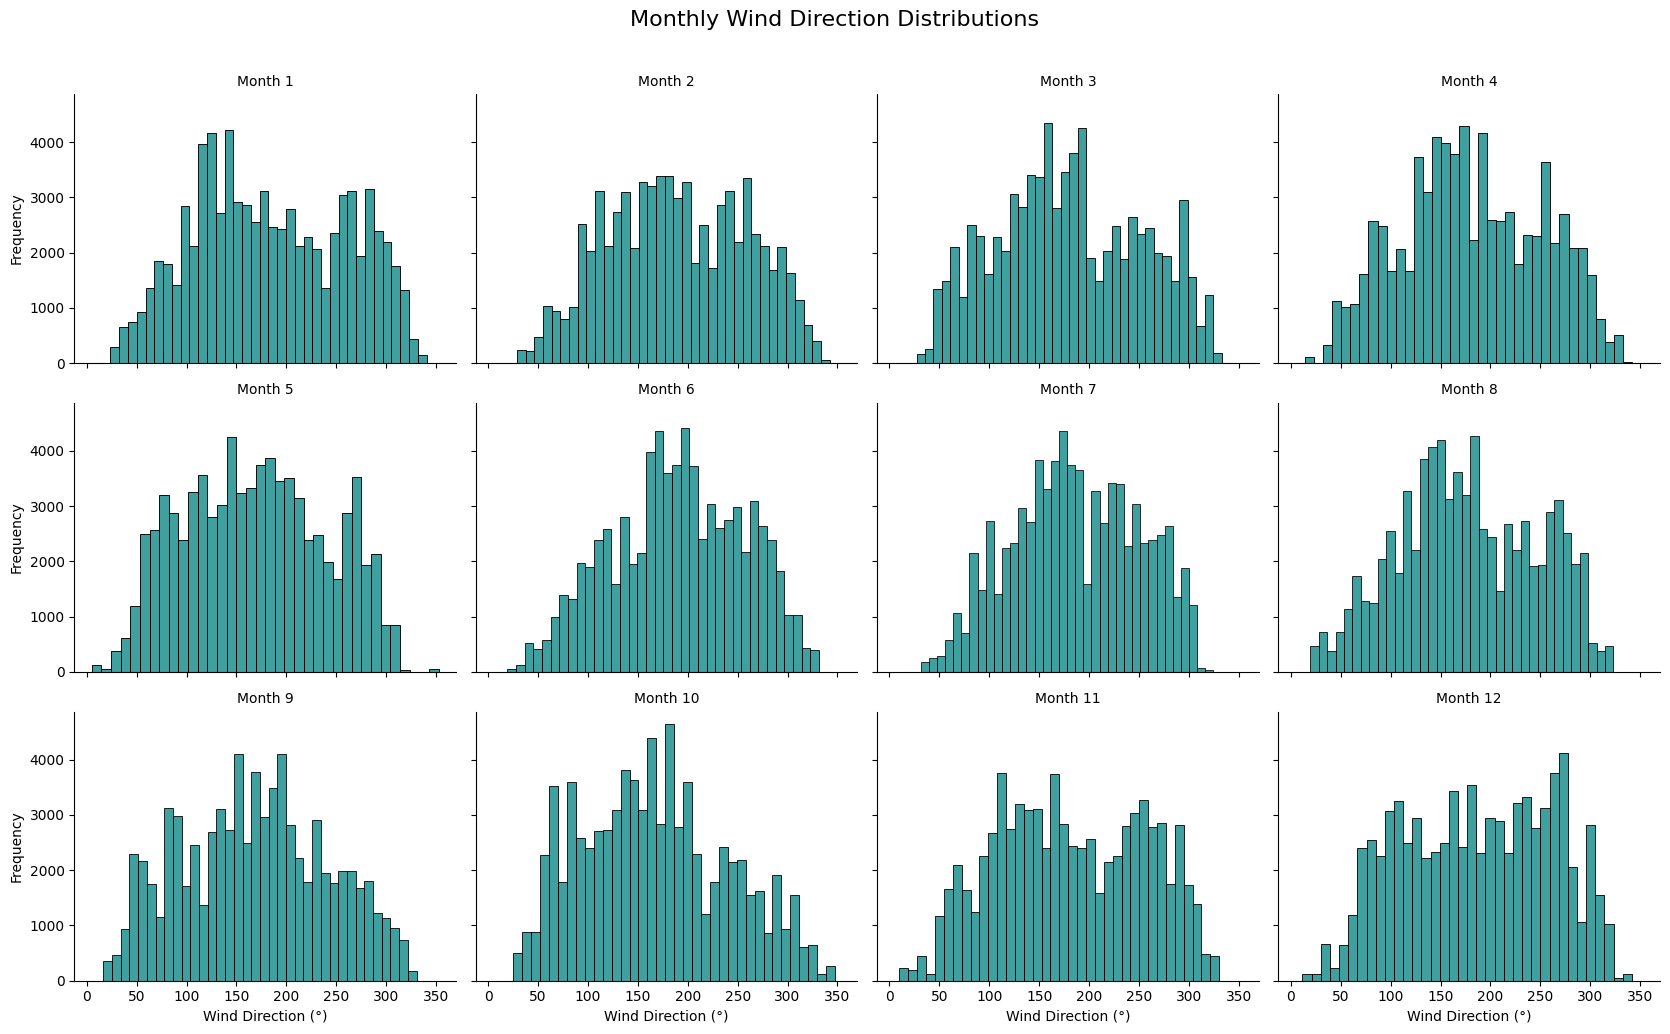

In [9]:
# Monthly wind direction histograms (small multiples)
g = sns.FacetGrid(df, col="month", col_wrap=4, height=3.5, aspect=1.2)
g.map_dataframe(sns.histplot, x="windDirection", bins=36, color="teal")
g.set_axis_labels("Wind Direction (°)", "Frequency")
g.set_titles("Month {col_name}")
plt.subplots_adjust(top=0.9)
g.fig.suptitle("Monthly Wind Direction Distributions", fontsize=16)
plt.show()

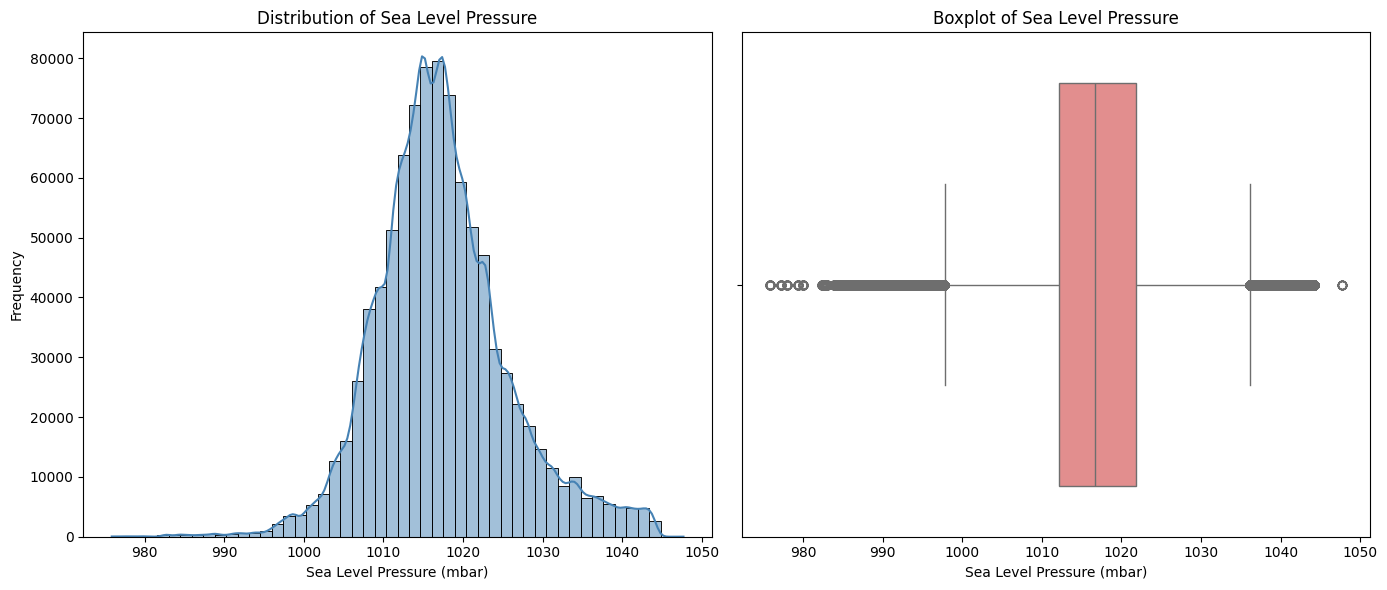

/tmp/ipykernel_4287/2833460741.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="month", y="seaLvlPressure", data=df, palette="coolwarm")


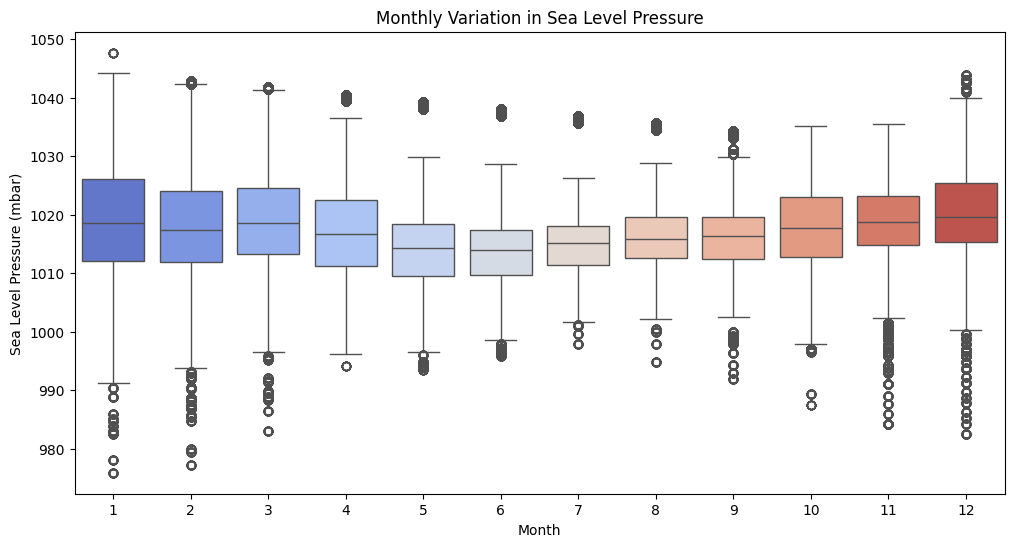

In [10]:
# Distribution + Boxplot for sea level pressure
plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
sns.histplot(df['seaLvlPressure'], bins=50, kde=True, color="steelblue")
plt.title("Distribution of Sea Level Pressure")
plt.xlabel("Sea Level Pressure (mbar)")
plt.ylabel("Frequency")

plt.subplot(1,2,2)
sns.boxplot(x=df['seaLvlPressure'], color="lightcoral")
plt.title("Boxplot of Sea Level Pressure")
plt.xlabel("Sea Level Pressure (mbar)")

plt.tight_layout()
plt.show()

# Monthly variation
plt.figure(figsize=(12,6))
sns.boxplot(x="month", y="seaLvlPressure", data=df, palette="coolwarm")
plt.title("Monthly Variation in Sea Level Pressure")
plt.xlabel("Month")
plt.ylabel("Sea Level Pressure (mbar)")
plt.show()


<font size="6">Multivariate Analysis</font>

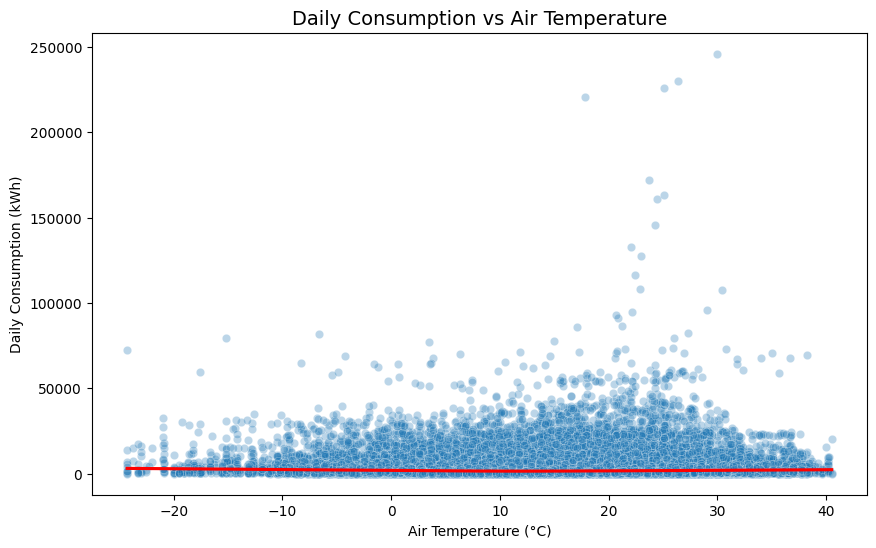

/tmp/ipykernel_4287/1585344037.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = df.groupby("temp_bin")["daily_consumption"].mean()


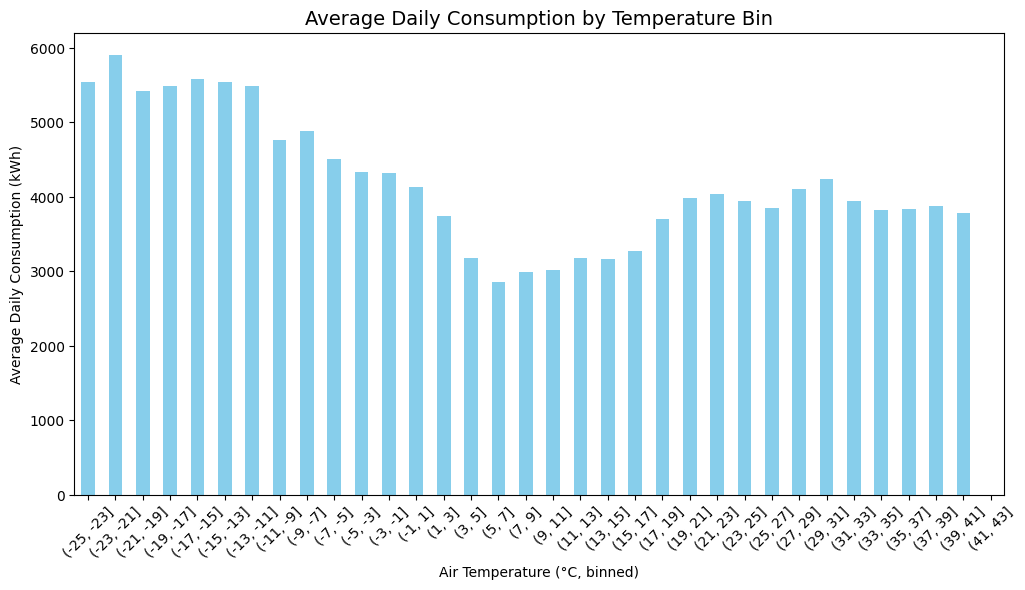

In [12]:
# Scatterplot with trendline
plt.figure(figsize=(10,6))
sns.scatterplot(x="airTemperature", y="daily_consumption", 
                data=df.sample(50000, random_state=42), alpha=0.3)
sns.regplot(x="airTemperature", y="daily_consumption", 
            data=df.sample(50000, random_state=42), scatter=False, 
            lowess=True, color="red")
plt.title("Daily Consumption vs Air Temperature", fontsize=14)
plt.xlabel("Air Temperature (°C)")
plt.ylabel("Daily Consumption (kWh)")
plt.show()

# Binned average consumption
df["temp_bin"] = pd.cut(df["airTemperature"], bins=np.arange(-25, 45, 2))
bin_means = df.groupby("temp_bin")["daily_consumption"].mean()

plt.figure(figsize=(12,6))
bin_means.plot(kind="bar", color="skyblue")
plt.title("Average Daily Consumption by Temperature Bin", fontsize=14)
plt.xlabel("Air Temperature (°C, binned)")
plt.ylabel("Average Daily Consumption (kWh)")
plt.xticks(rotation=45)
plt.show()


In [13]:
df.head()

date            building_id  daily_consumption site_id    sqft  \
0 2016-01-01  Robin_public_Carolina           2183.750   Robin  118231   
1 2016-01-02  Robin_public_Carolina           2205.563   Robin  118231   
2 2016-01-03  Robin_public_Carolina           2108.750   Robin  118231   
3 2016-01-04  Robin_public_Carolina           3536.562   Robin  118231   
4 2016-01-05  Robin_public_Carolina           3771.376   Robin  118231   

       sqm       timezone sub_primaryspaceusage primaryspaceusage       lat  \
0  10984.0  Europe/London               Library   Public services  51.51879   
1  10984.0  Europe/London               Library   Public services  51.51879   
2  10984.0  Europe/London               Library   Public services  51.51879   
3  10984.0  Europe/London               Library   Public services  51.51879   
4  10984.0  Europe/London               Library   Public services  51.51879   

   ...  windDirection  windSpeed  is_outlier  month  year  day_of_week  \
0  ...     116.666667   4.470833       False      1  2016            4   
1  ...     166.666667   7.241667       False      1  2016            5   
2  ...     187.916667   5.633333       False      1  2016            6   
3  ...     177.083333   4.145833       False      1  2016            0   
4  ...     175.416667   2.750000       False      1  2016            1   

   is_weekend  log_daily_consumption   log_sqm  temp_bin  
0       False               7.689257  9.304286    (5, 7]  
1        True               7.699191  9.304286   (9, 11]  
2        True               7.654325  9.304286    (7, 9]  
3       False               8.171193  9.304286    (7, 9]  
4       False               8.235460  9.304286    (7, 9]  

[5 rows x 25 columns]

In [14]:
df.drop('temp_bin', axis=1)

date            building_id  daily_consumption site_id    sqft  \
0      2016-01-01  Robin_public_Carolina           2183.750   Robin  118231   
1      2016-01-02  Robin_public_Carolina           2205.563   Robin  118231   
2      2016-01-03  Robin_public_Carolina           2108.750   Robin  118231   
3      2016-01-04  Robin_public_Carolina           3536.562   Robin  118231   
4      2016-01-05  Robin_public_Carolina           3771.376   Robin  118231   
...           ...                    ...                ...     ...     ...   
918131 2017-12-27    Mouse_health_Estela           7392.000   Mouse  185064   
918132 2017-12-28    Mouse_health_Estela           7392.000   Mouse  185064   
918133 2017-12-29    Mouse_health_Estela           7392.000   Mouse  185064   
918134 2017-12-30    Mouse_health_Estela           7392.000   Mouse  185064   
918135 2017-12-31    Mouse_health_Estela           7392.000   Mouse  185064   

            sqm       timezone sub_primaryspaceusage primaryspaceusage  \
0       10984.0  Europe/London               Library   Public services   
1       10984.0  Europe/London               Library   Public services   
2       10984.0  Europe/London               Library   Public services   
3       10984.0  Europe/London               Library   Public services   
4       10984.0  Europe/London               Library   Public services   
...         ...            ...                   ...               ...   
918131  17193.0  Europe/London              Hospital        Healthcare   
918132  17193.0  Europe/London              Hospital        Healthcare   
918133  17193.0  Europe/London              Hospital        Healthcare   
918134  17193.0  Europe/London              Hospital        Healthcare   
918135  17193.0  Europe/London              Hospital        Healthcare   

              lat  ...  seaLvlPressure  windDirection  windSpeed  is_outlier  \
0       51.518790  ...     1016.941667     116.666667   4.470833       False   
1       51.518790  ...      998.087500     166.666667   7.241667       False   
2       51.518790  ...      991.837500     187.916667   5.633333       False   
3       51.518790  ...      982.766667     177.083333   4.145833       False   
4       51.518790  ...      984.712500     175.416667   2.750000       False   
...           ...  ...             ...            ...        ...         ...   
918131  51.521939  ...      987.766667     271.666667   5.162500       False   
918132  51.521939  ...     1003.508333     254.583333   3.616667       False   
918133  51.521939  ...      997.916667     198.750000   5.783333       False   
918134  51.521939  ...      996.650000     227.500000   7.866667       False   
918135  51.521939  ...      994.866667     215.833333   7.487500       False   

        month  year  day_of_week  is_weekend  log_daily_consumption   log_sqm  
0           1  2016            4       False               7.689257  9.304286  
1           1  2016            5        True               7.699191  9.304286  
2           1  2016            6        True               7.654325  9.304286  
3           1  2016            0       False               8.171193  9.304286  
4           1  2016            1       False               8.235460  9.304286  
...       ...   ...          ...         ...                    ...       ...  
918131     12  2017            2       False               8.908289  9.752316  
918132     12  2017            3       False               8.908289  9.752316  
918133     12  2017            4       False               8.908289  9.752316  
918134     12  2017            5        True               8.908289  9.752316  
918135     12  2017            6        True               8.908289  9.752316  

[918136 rows x 24 columns]

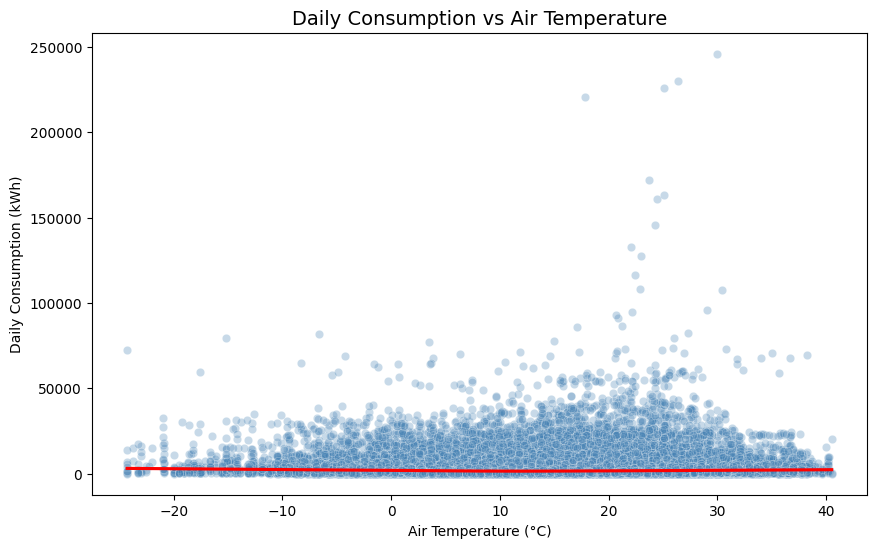

In [15]:
# 1. Scatterplot with trendline (sampled for performance)
plt.figure(figsize=(10,6))
sns.scatterplot(
    x="airTemperature", 
    y="daily_consumption", 
    data=df.sample(50000, random_state=42), 
    alpha=0.3, color="steelblue"
)
sns.regplot(
    x="airTemperature", 
    y="daily_consumption", 
    data=df.sample(50000, random_state=42), 
    scatter=False, 
    lowess=True, 
    color="red"
)
plt.title("Daily Consumption vs Air Temperature", fontsize=14)
plt.xlabel("Air Temperature (°C)")
plt.ylabel("Daily Consumption (kWh)")
plt.show()

/tmp/ipykernel_4287/1743942101.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = df.groupby("temp_bin")["daily_consumption"].mean()


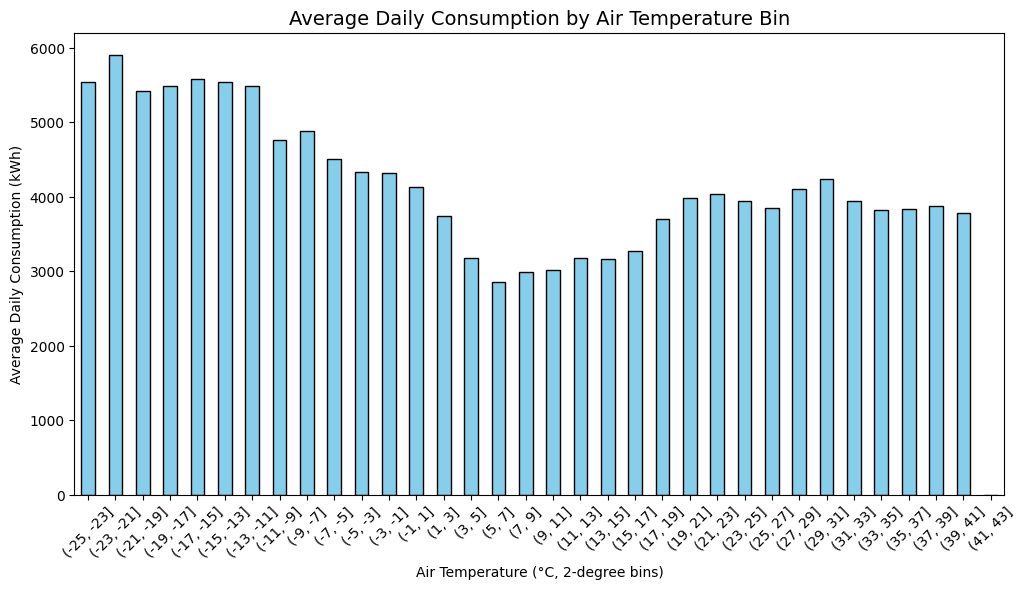

In [16]:
# 2. Binned average consumption
df["temp_bin"] = pd.cut(df["airTemperature"], bins=np.arange(-25, 45, 2))
bin_means = df.groupby("temp_bin")["daily_consumption"].mean()

plt.figure(figsize=(12,6))
bin_means.plot(kind="bar", color="skyblue", edgecolor="black")
plt.title("Average Daily Consumption by Air Temperature Bin", fontsize=14)
plt.xlabel("Air Temperature (°C, 2-degree bins)")
plt.ylabel("Average Daily Consumption (kWh)")
plt.xticks(rotation=45)
plt.show()

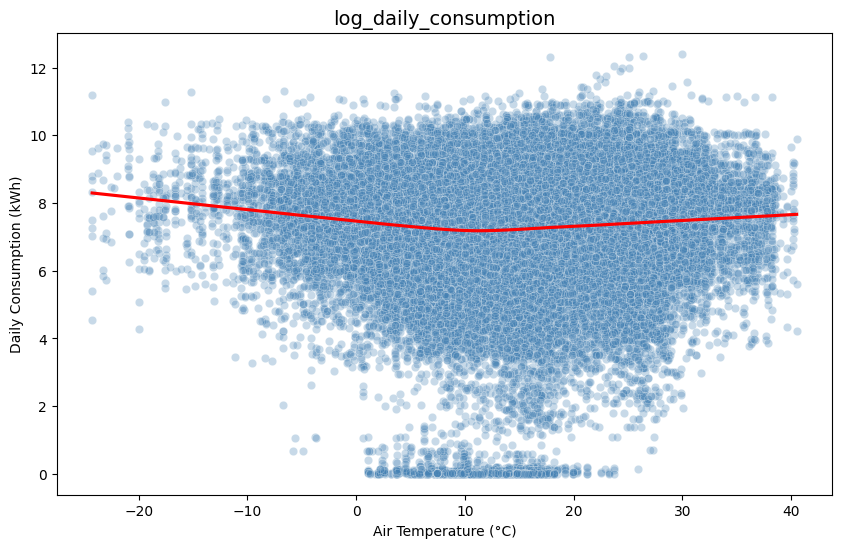

In [18]:
# 1. Scatterplot with trendline (sampled for performance) but with log_daily_consumption
plt.figure(figsize=(10,6))
sns.scatterplot(
    x="airTemperature", 
    y="log_daily_consumption", 
    data=df.sample(50000, random_state=42), 
    alpha=0.3, color="steelblue"
)
sns.regplot(
    x="airTemperature", 
    y="log_daily_consumption", 
    data=df.sample(50000, random_state=42), 
    scatter=False, 
    lowess=True, 
    color="red"
)
plt.title("log_daily_consumption", fontsize=14)
plt.xlabel("Air Temperature (°C)")
plt.ylabel("Daily Consumption (kWh)")
plt.show()

In [2]:
# Load intermediate dataset
df = pd.read_parquet("intermediate_set.parquet", engine="fastparquet")

In [3]:
df.head()

date            building_id  daily_consumption site_id    sqft  \
0 2016-01-01  Robin_public_Carolina           2183.750   Robin  118231   
1 2016-01-02  Robin_public_Carolina           2205.563   Robin  118231   
2 2016-01-03  Robin_public_Carolina           2108.750   Robin  118231   
3 2016-01-04  Robin_public_Carolina           3536.562   Robin  118231   
4 2016-01-05  Robin_public_Carolina           3771.376   Robin  118231   

       sqm       timezone sub_primaryspaceusage primaryspaceusage       lat  \
0  10984.0  Europe/London               Library   Public services  51.51879   
1  10984.0  Europe/London               Library   Public services  51.51879   
2  10984.0  Europe/London               Library   Public services  51.51879   
3  10984.0  Europe/London               Library   Public services  51.51879   
4  10984.0  Europe/London               Library   Public services  51.51879   

   ...  seaLvlPressure  windDirection  windSpeed  is_outlier  month  year  \
0  ...     1016.941667     116.666667   4.470833       False      1  2016   
1  ...      998.087500     166.666667   7.241667       False      1  2016   
2  ...      991.837500     187.916667   5.633333       False      1  2016   
3  ...      982.766667     177.083333   4.145833       False      1  2016   
4  ...      984.712500     175.416667   2.750000       False      1  2016   

   day_of_week  is_weekend  log_daily_consumption   log_sqm  
0            4       False               7.689257  9.304286  
1            5        True               7.699191  9.304286  
2            6        True               7.654325  9.304286  
3            0       False               8.171193  9.304286  
4            1       False               8.235460  9.304286  

[5 rows x 24 columns]

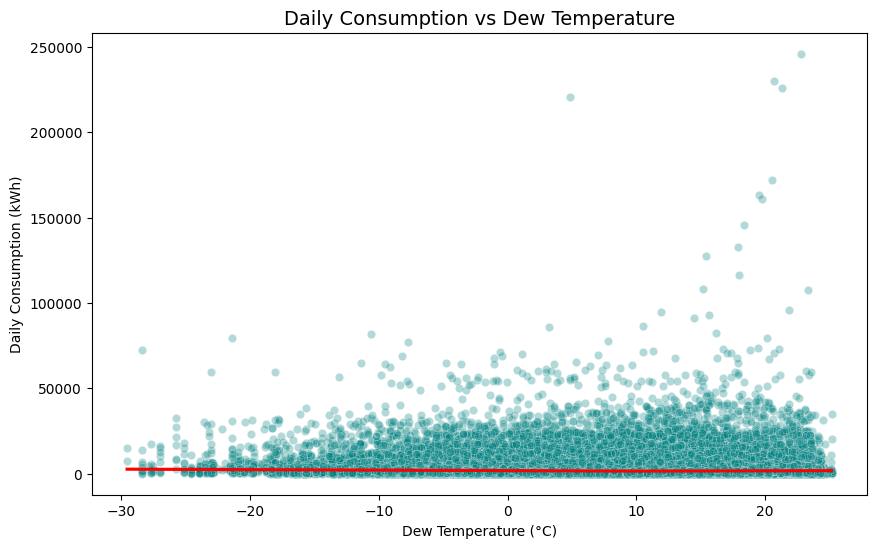

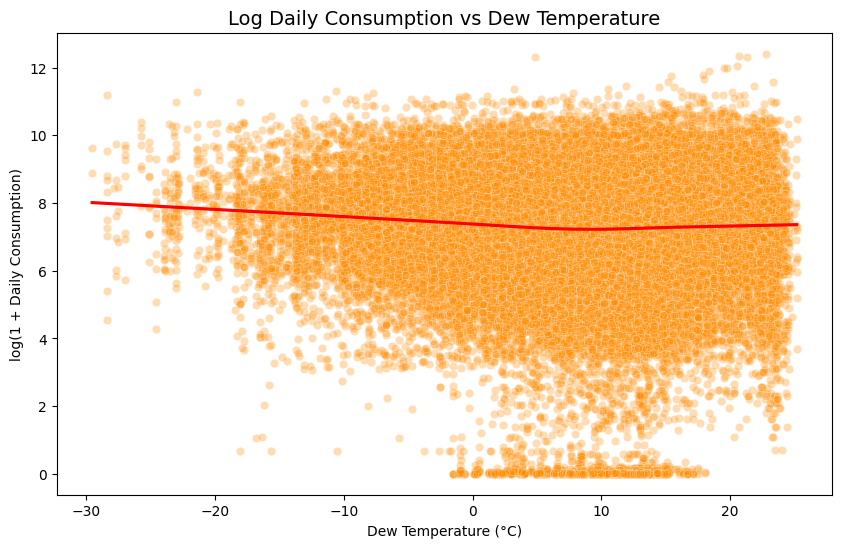

/tmp/ipykernel_6021/4152165835.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means_dew = df.groupby("dew_bin")["daily_consumption"].mean()


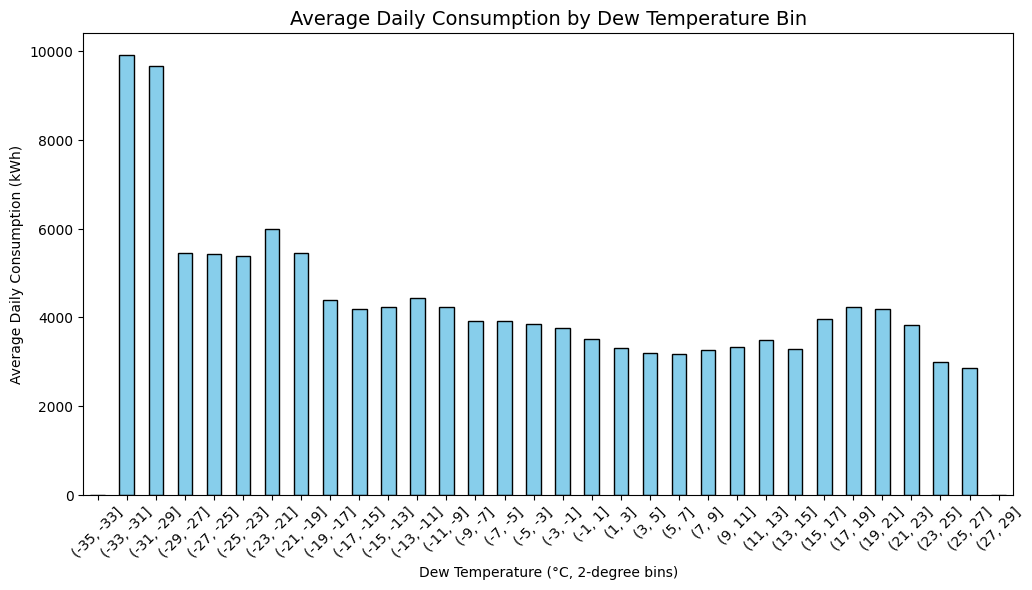

In [4]:
# 1. Scatterplot (raw daily consumption)
plt.figure(figsize=(10,6))
sns.scatterplot(
    x="dewTemperature", 
    y="daily_consumption", 
    data=df.sample(50000, random_state=42), 
    alpha=0.3, color="teal"
)
sns.regplot(
    x="dewTemperature", 
    y="daily_consumption", 
    data=df.sample(50000, random_state=42), 
    scatter=False, 
    lowess=True, 
    color="red"
)
plt.title("Daily Consumption vs Dew Temperature", fontsize=14)
plt.xlabel("Dew Temperature (°C)")
plt.ylabel("Daily Consumption (kWh)")
plt.show()

# 2. Scatterplot (log target)
plt.figure(figsize=(10,6))
sns.scatterplot(
    x="dewTemperature", 
    y="log_daily_consumption", 
    data=df.sample(50000, random_state=42), 
    alpha=0.3, color="darkorange"
)
sns.regplot(
    x="dewTemperature", 
    y="log_daily_consumption", 
    data=df.sample(50000, random_state=42), 
    scatter=False, 
    lowess=True, 
    color="red"
)
plt.title("Log Daily Consumption vs Dew Temperature", fontsize=14)
plt.xlabel("Dew Temperature (°C)")
plt.ylabel("log(1 + Daily Consumption)")
plt.show()

# 3. Binned averages (raw daily consumption)
df["dew_bin"] = pd.cut(df["dewTemperature"], bins=np.arange(-35, 30, 2))
bin_means_dew = df.groupby("dew_bin")["daily_consumption"].mean()

plt.figure(figsize=(12,6))
bin_means_dew.plot(kind="bar", color="skyblue", edgecolor="black")
plt.title("Average Daily Consumption by Dew Temperature Bin", fontsize=14)
plt.xlabel("Dew Temperature (°C, 2-degree bins)")
plt.ylabel("Average Daily Consumption (kWh)")
plt.xticks(rotation=45)
plt.show()


/tmp/ipykernel_6021/3945947973.py:40: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = df.groupby("wind_bin")["daily_consumption"].mean()


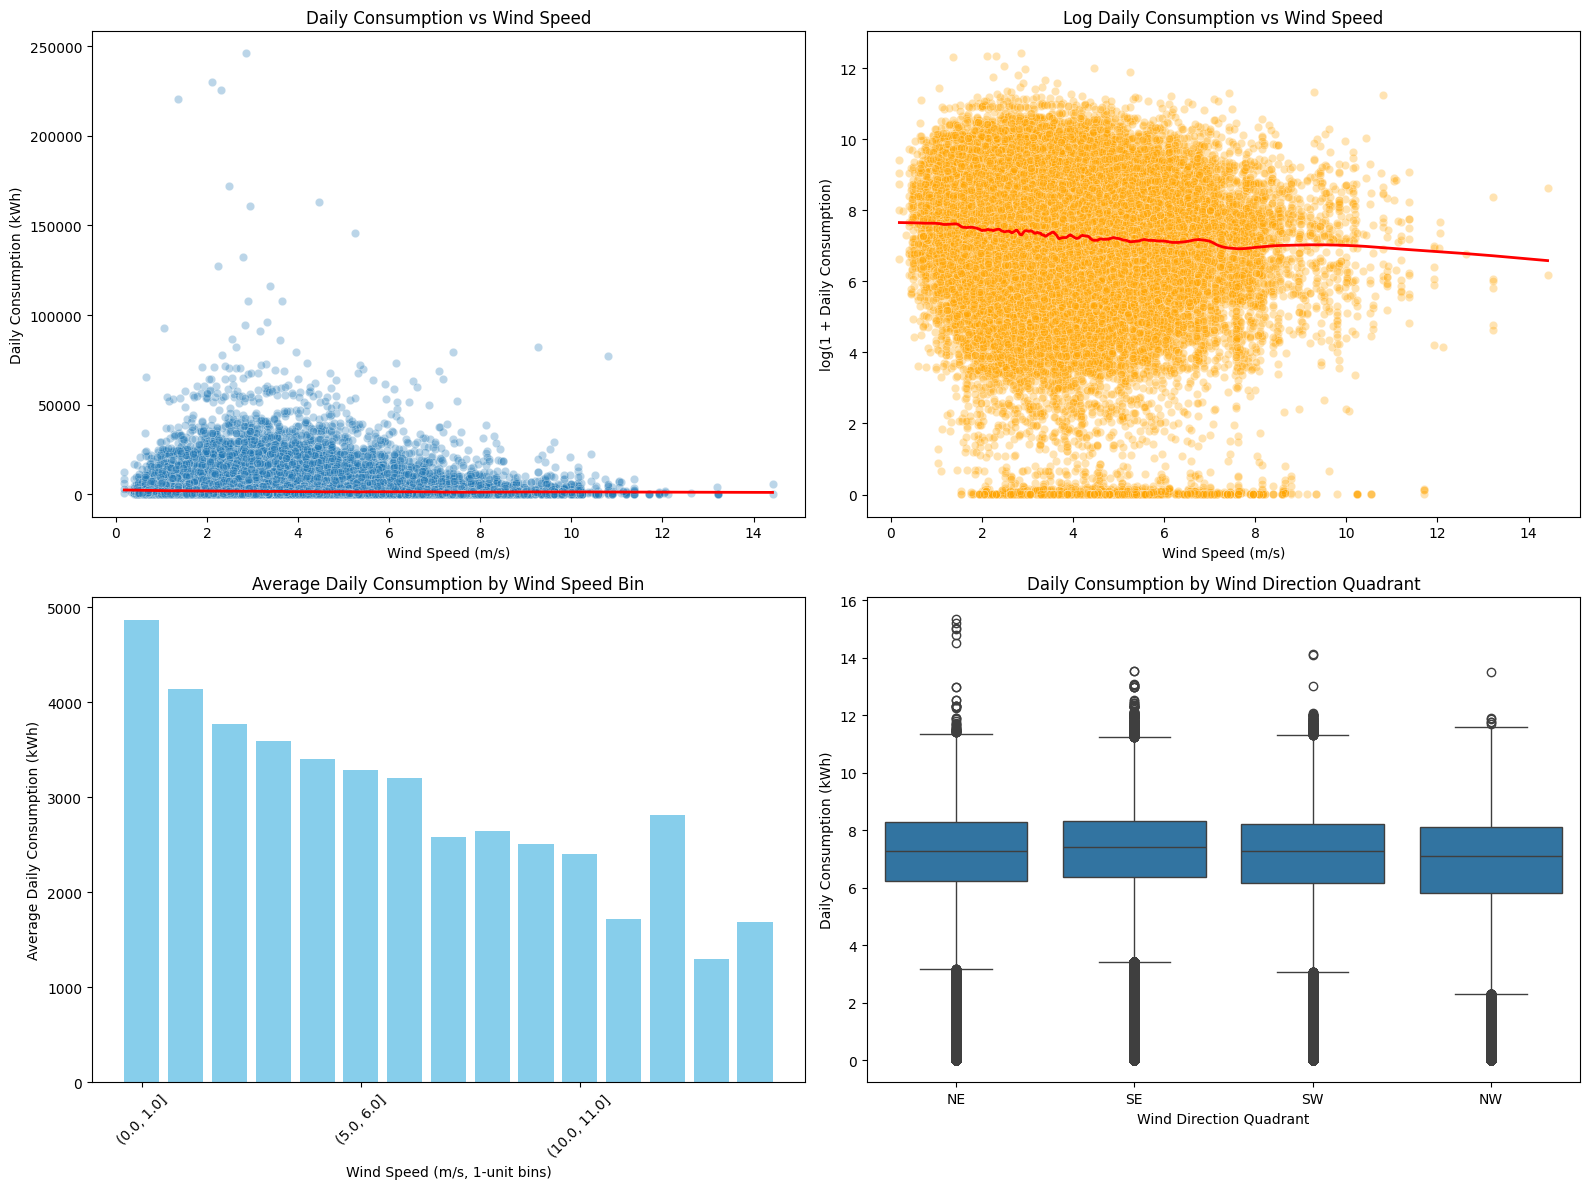

In [8]:
from statsmodels.nonparametric.smoothers_lowess import lowess

# WIND SPEED vs CONSUMPTION

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Sample for clarity
df_sample = df.sample(50000, random_state=42)

# --- Scatter (raw consumption)
sns.scatterplot(
    x="windSpeed", y="daily_consumption",
    data=df_sample, alpha=0.3, ax=axes[0,0]
)

# LOWESS smoothing
lowess_fit = lowess(df_sample["daily_consumption"], df_sample["windSpeed"], frac=0.05)
axes[0,0].plot(lowess_fit[:,0], lowess_fit[:,1], color="red", linewidth=2)

axes[0,0].set_title("Daily Consumption vs Wind Speed")
axes[0,0].set_xlabel("Wind Speed (m/s)")
axes[0,0].set_ylabel("Daily Consumption (kWh)")

# --- Scatter (log consumption)
sns.scatterplot(
    x="windSpeed", y="log_daily_consumption",
    data=df_sample, alpha=0.3, ax=axes[0,1], color="orange"
)

# LOWESS smoothing
lowess_fit_log = lowess(df_sample["log_daily_consumption"], df_sample["windSpeed"], frac=0.05)
axes[0,1].plot(lowess_fit_log[:,0], lowess_fit_log[:,1], color="red", linewidth=2)

axes[0,1].set_title("Log Daily Consumption vs Wind Speed")
axes[0,1].set_xlabel("Wind Speed (m/s)")
axes[0,1].set_ylabel("log(1 + Daily Consumption)")

# --- Binned averages
df["wind_bin"] = pd.cut(df["windSpeed"], bins=np.arange(0, df["windSpeed"].max()+1, 1))
bin_means = df.groupby("wind_bin")["daily_consumption"].mean()

axes[1,0].bar(
    range(len(bin_means)), bin_means, width=0.8, color="skyblue"
)
axes[1,0].set_xticks(range(len(bin_means))[::5])
axes[1,0].set_xticklabels([str(b) for b in bin_means.index[::5]], rotation=45)
axes[1,0].set_title("Average Daily Consumption by Wind Speed Bin")
axes[1,0].set_xlabel("Wind Speed (m/s, 1-unit bins)")
axes[1,0].set_ylabel("Average Daily Consumption (kWh)")

# WIND DIRECTION vs CONSUMPTION

def wind_quadrant(deg):
    if 0 <= deg < 90: return "NE"
    elif 90 <= deg < 180: return "SE"
    elif 180 <= deg < 270: return "SW"
    else: return "NW"

df["wind_quadrant"] = df["windDirection"].apply(wind_quadrant)

sns.boxplot(
    x="wind_quadrant", y="log_daily_consumption",
    data=df, order=["NE", "SE", "SW", "NW"], ax=axes[1,1]
)
axes[1,1].set_title("Daily Consumption by Wind Direction Quadrant")
axes[1,1].set_xlabel("Wind Direction Quadrant")
axes[1,1].set_ylabel("Daily Consumption (kWh)")

plt.tight_layout()
plt.show()

In [2]:
# Load intermediate dataset
df = pd.read_parquet("intermediate_set.parquet", engine="fastparquet")

In [3]:
df.head()

date            building_id  daily_consumption site_id    sqft  \
0 2016-01-01  Robin_public_Carolina           2183.750   Robin  118231   
1 2016-01-02  Robin_public_Carolina           2205.563   Robin  118231   
2 2016-01-03  Robin_public_Carolina           2108.750   Robin  118231   
3 2016-01-04  Robin_public_Carolina           3536.562   Robin  118231   
4 2016-01-05  Robin_public_Carolina           3771.376   Robin  118231   

       sqm       timezone sub_primaryspaceusage primaryspaceusage       lat  \
0  10984.0  Europe/London               Library   Public services  51.51879   
1  10984.0  Europe/London               Library   Public services  51.51879   
2  10984.0  Europe/London               Library   Public services  51.51879   
3  10984.0  Europe/London               Library   Public services  51.51879   
4  10984.0  Europe/London               Library   Public services  51.51879   

   ...  seaLvlPressure  windDirection  windSpeed  is_outlier  month  year  \
0  ...     1016.941667     116.666667   4.470833       False      1  2016   
1  ...      998.087500     166.666667   7.241667       False      1  2016   
2  ...      991.837500     187.916667   5.633333       False      1  2016   
3  ...      982.766667     177.083333   4.145833       False      1  2016   
4  ...      984.712500     175.416667   2.750000       False      1  2016   

   day_of_week  is_weekend  log_daily_consumption   log_sqm  
0            4       False               7.689257  9.304286  
1            5        True               7.699191  9.304286  
2            6        True               7.654325  9.304286  
3            0       False               8.171193  9.304286  
4            1       False               8.235460  9.304286  

[5 rows x 24 columns]

/tmp/ipykernel_33401/3096481608.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means_pressure = df.groupby('pressure_bin')['daily_consumption'].mean()


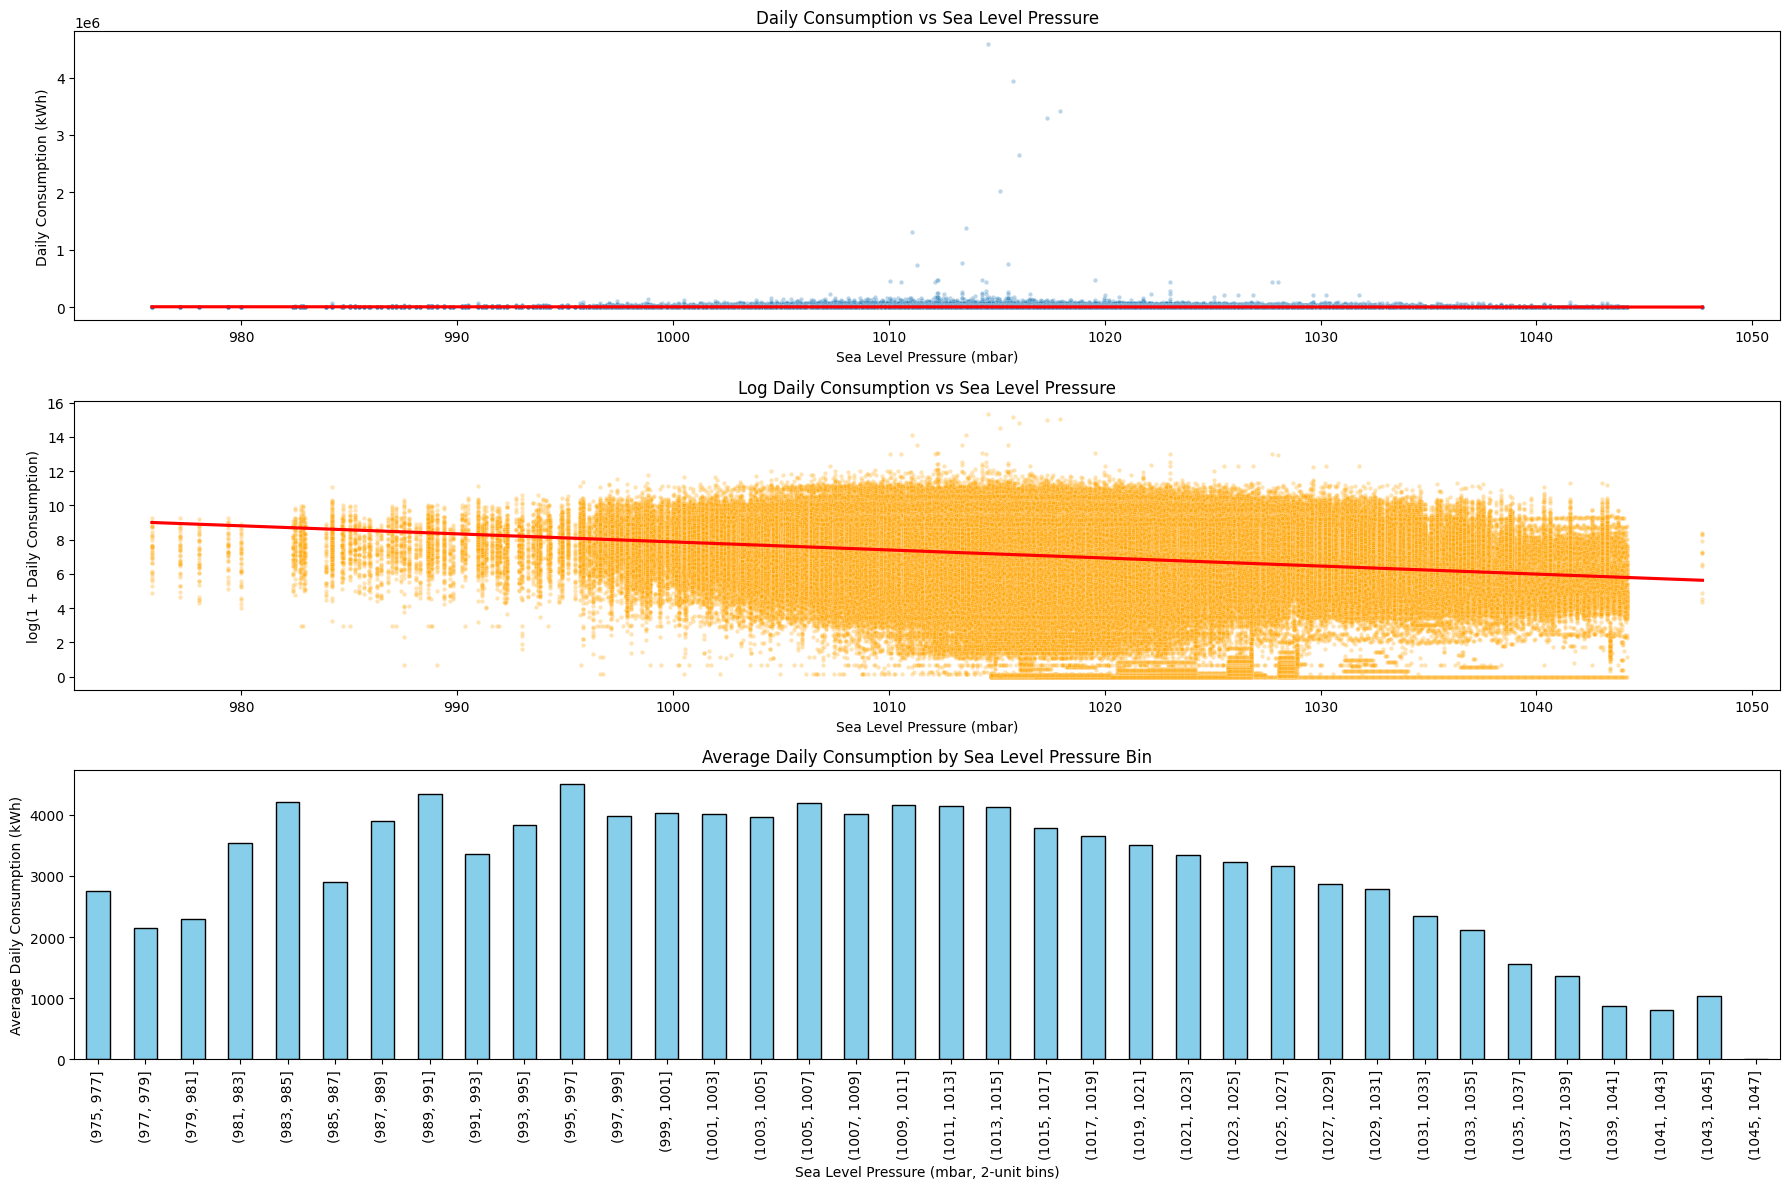

In [10]:
# Scatter plot: daily consumption vs sea-level pressure
plt.figure(figsize=(18, 12))

# 1. Raw scatter
plt.subplot(3, 1, 1)
sns.scatterplot(x='seaLvlPressure', y='daily_consumption', data=df, alpha=0.3, s=10)
sns.regplot(x='seaLvlPressure', y='daily_consumption', data=df, scatter=False, color='red')
plt.title("Daily Consumption vs Sea Level Pressure")
plt.xlabel("Sea Level Pressure (mbar)")
plt.ylabel("Daily Consumption (kWh)")

# 2. Log-transformed consumption scatter
plt.subplot(3, 1, 2)
sns.scatterplot(x='seaLvlPressure', y='log_daily_consumption', data=df, alpha=0.3, s=10, color="orange")
sns.regplot(x='seaLvlPressure', y='log_daily_consumption', data=df, scatter=False, color='red')
plt.title("Log Daily Consumption vs Sea Level Pressure")
plt.xlabel("Sea Level Pressure (mbar)")
plt.ylabel("log(1 + Daily Consumption)")

# 3. Binned averages
plt.subplot(3, 1, 3)
df['pressure_bin'] = pd.cut(df['seaLvlPressure'], bins=np.arange(int(df['seaLvlPressure'].min()), 
                                                                  int(df['seaLvlPressure'].max())+2, 2))
bin_means_pressure = df.groupby('pressure_bin')['daily_consumption'].mean()

bin_means_pressure.plot(kind='bar', color="skyblue", edgecolor="black")
plt.title("Average Daily Consumption by Sea Level Pressure Bin")
plt.xlabel("Sea Level Pressure (mbar, 2-unit bins)")
plt.ylabel("Average Daily Consumption (kWh)")

plt.tight_layout()
plt.show()


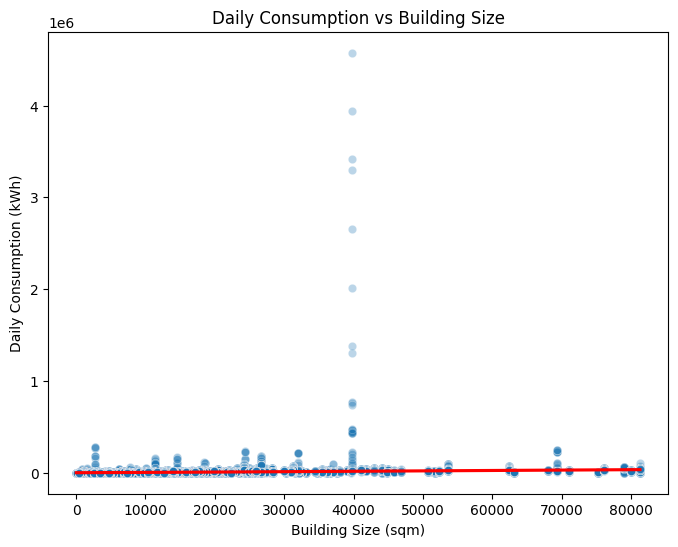

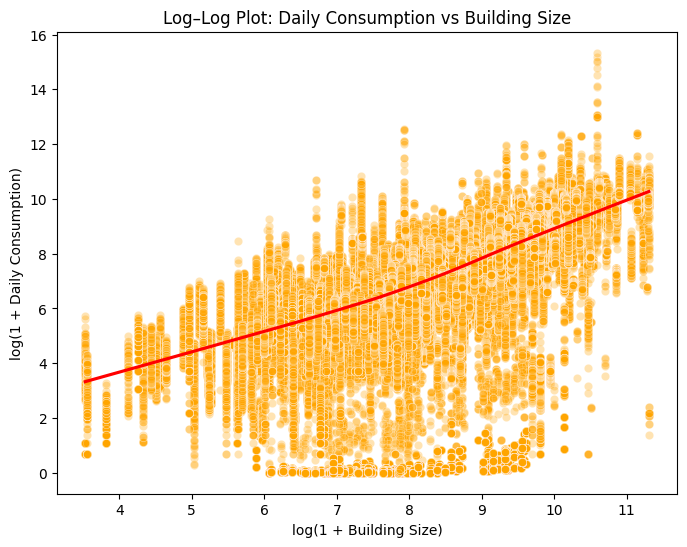

/tmp/ipykernel_23323/3551316772.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = df.groupby('size_bin')['daily_consumption'].mean()


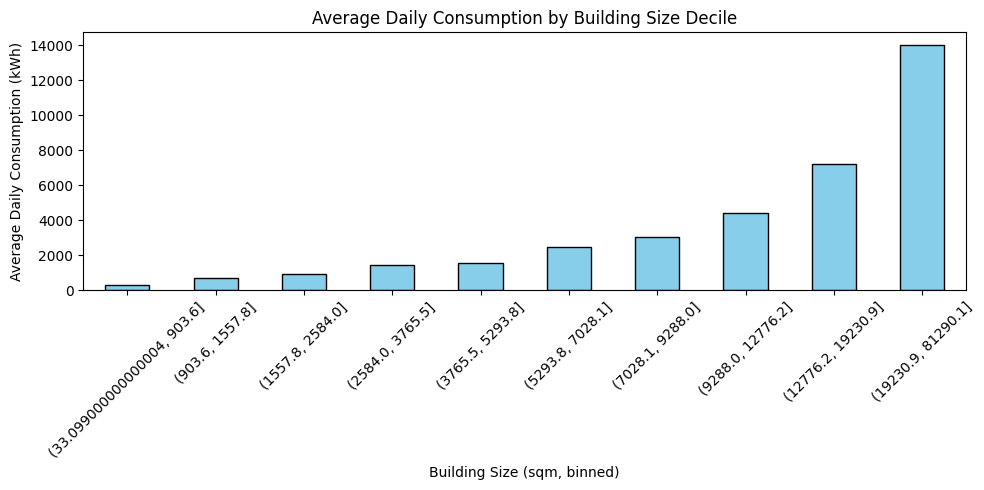

In [5]:

# --- 1. Scatter plot: raw values ---
plt.figure(figsize=(8, 6))
sns.scatterplot(x='sqm', y='daily_consumption', data=df, alpha=0.3)
sns.regplot(x='sqm', y='daily_consumption', data=df, scatter=False, color='red', lowess=True)
plt.title('Daily Consumption vs Building Size')
plt.xlabel('Building Size (sqm)')
plt.ylabel('Daily Consumption (kWh)')
plt.show()

# --- 2. Log–log scatter plot ---
plt.figure(figsize=(8, 6))
sns.scatterplot(x=np.log1p(df['sqm']), y=np.log1p(df['daily_consumption']),
                alpha=0.3, color='orange')
sns.regplot(x=np.log1p(df['sqm']), y=np.log1p(df['daily_consumption']),
            scatter=False, color='red', lowess=True)
plt.title('Log–Log Plot: Daily Consumption vs Building Size')
plt.xlabel('log(1 + Building Size)')
plt.ylabel('log(1 + Daily Consumption)')
plt.show()

# --- 3. Binned averages ---
df['size_bin'] = pd.qcut(df['sqm'], q=10, duplicates='drop')
bin_means = df.groupby('size_bin')['daily_consumption'].mean()

plt.figure(figsize=(10, 5))
bin_means.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Average Daily Consumption by Building Size Decile')
plt.xlabel('Building Size (sqm, binned)')
plt.ylabel('Average Daily Consumption (kWh)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


/tmp/ipykernel_23323/1747508334.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


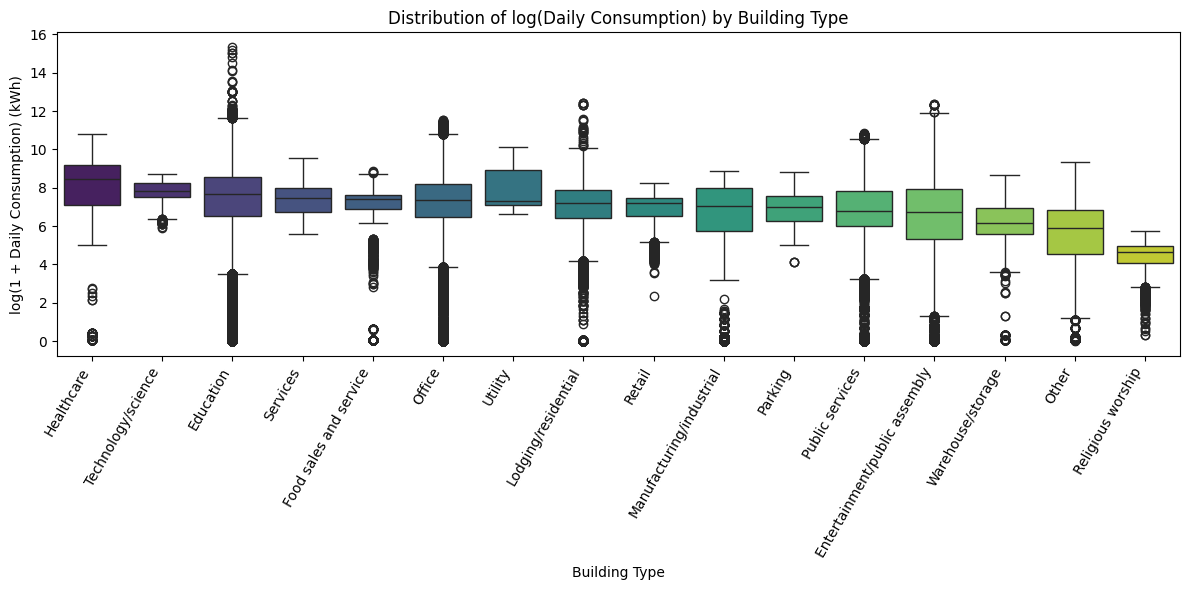

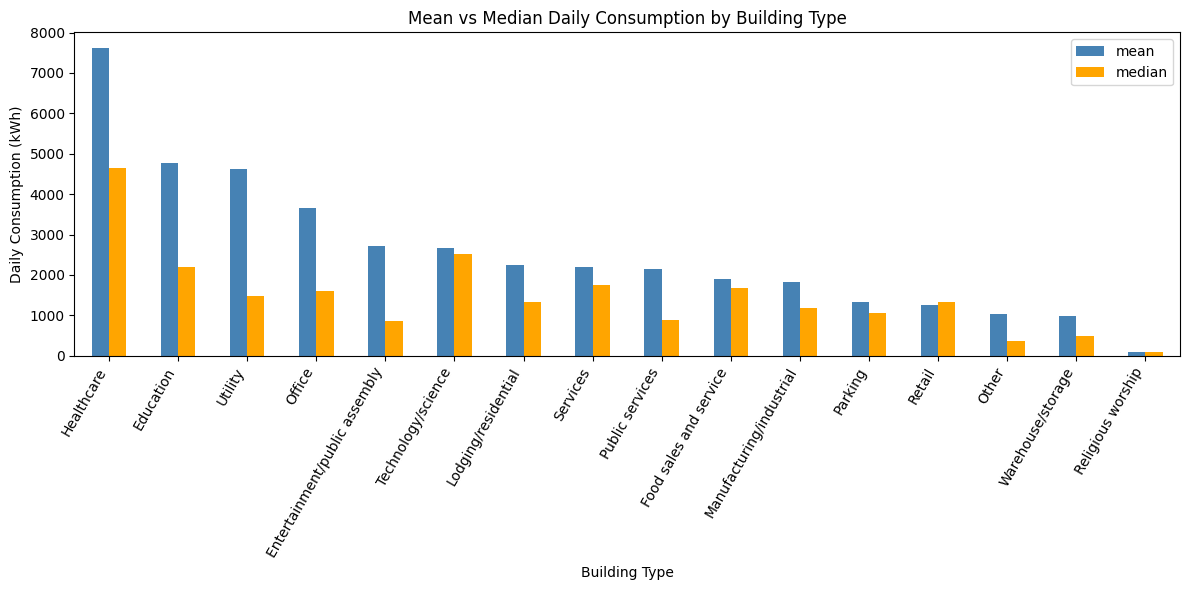

/tmp/ipykernel_23323/1747508334.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


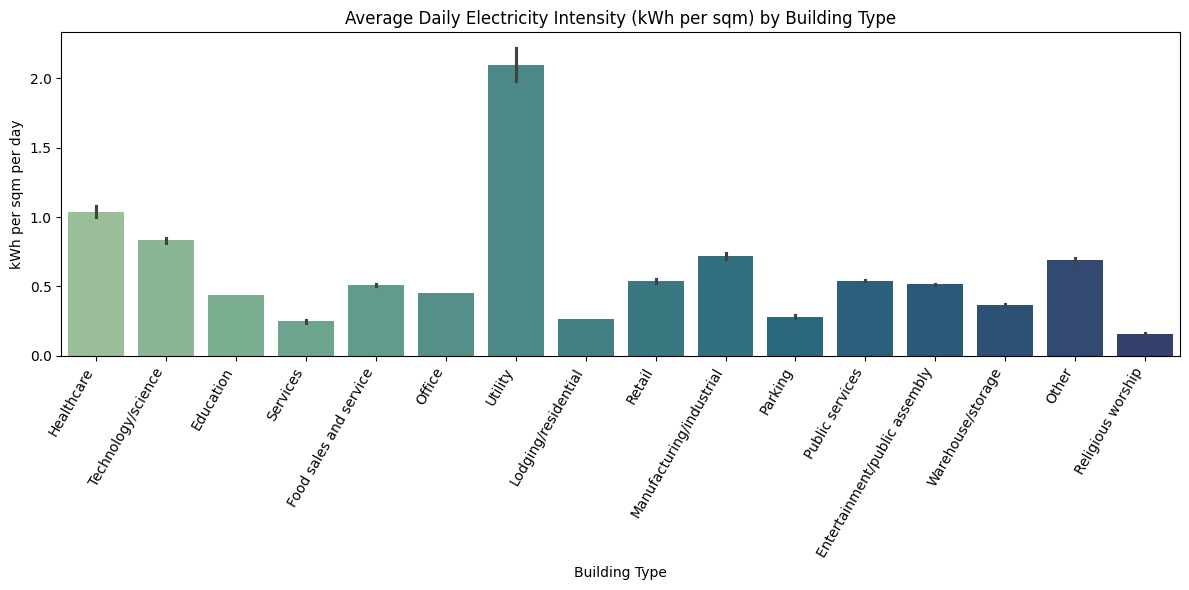

In [6]:
# --- 1. Boxplot of log consumption by building type ---
plt.figure(figsize=(12, 6))
order = df.groupby("primaryspaceusage")["daily_consumption"].median().sort_values(ascending=False).index
sns.boxplot(
    data=df,
    x="primaryspaceusage",
    y="log_daily_consumption",
    order=order,
    palette="viridis"
)
plt.xticks(rotation=60, ha='right')
plt.title("Distribution of log(Daily Consumption) by Building Type")
plt.ylabel("log(1 + Daily Consumption) (kWh)")
plt.xlabel("Building Type")
plt.tight_layout()
plt.show()

# --- 2. Mean and median comparison ---
summary = df.groupby("primaryspaceusage")["daily_consumption"].agg(['mean', 'median']).sort_values(by='mean', ascending=False)
summary.plot(kind='bar', figsize=(12, 6), color=['steelblue', 'orange'])
plt.title("Mean vs Median Daily Consumption by Building Type")
plt.ylabel("Daily Consumption (kWh)")
plt.xlabel("Building Type")
plt.xticks(rotation=60, ha='right')
plt.tight_layout()
plt.show()

# --- 3. Normalized consumption (kWh per sqm) ---
df["consumption_per_sqm"] = df["daily_consumption"] / df["sqm"]
plt.figure(figsize=(12, 6))
sns.barplot(
    data=df,
    x="primaryspaceusage",
    y="consumption_per_sqm",
    order=order,
    palette="crest"
)
plt.xticks(rotation=60, ha='right')
plt.title("Average Daily Electricity Intensity (kWh per sqm) by Building Type")
plt.ylabel("kWh per sqm per day")
plt.xlabel("Building Type")
plt.tight_layout()
plt.show()


In [7]:
# Summary statistics by timezone
tz_summary = (
    df.groupby("timezone")["daily_consumption"]
    .agg(["count", "mean", "median"])
    .sort_values("mean", ascending=False)
)
print("Summary by timezone:\n", tz_summary)

Summary by timezone:
                 count         mean      median
timezone                                      
US/Central     185674  5522.734517  2552.00000
US/Pacific      58480  4437.795420  1836.47500
US/Mountain    104533  3471.065521  2033.96000
US/Eastern     412284  3360.116487  1435.11515
Europe/Dublin   26316  2336.322678  1447.75625
Europe/London  130849  1635.795725   321.40000


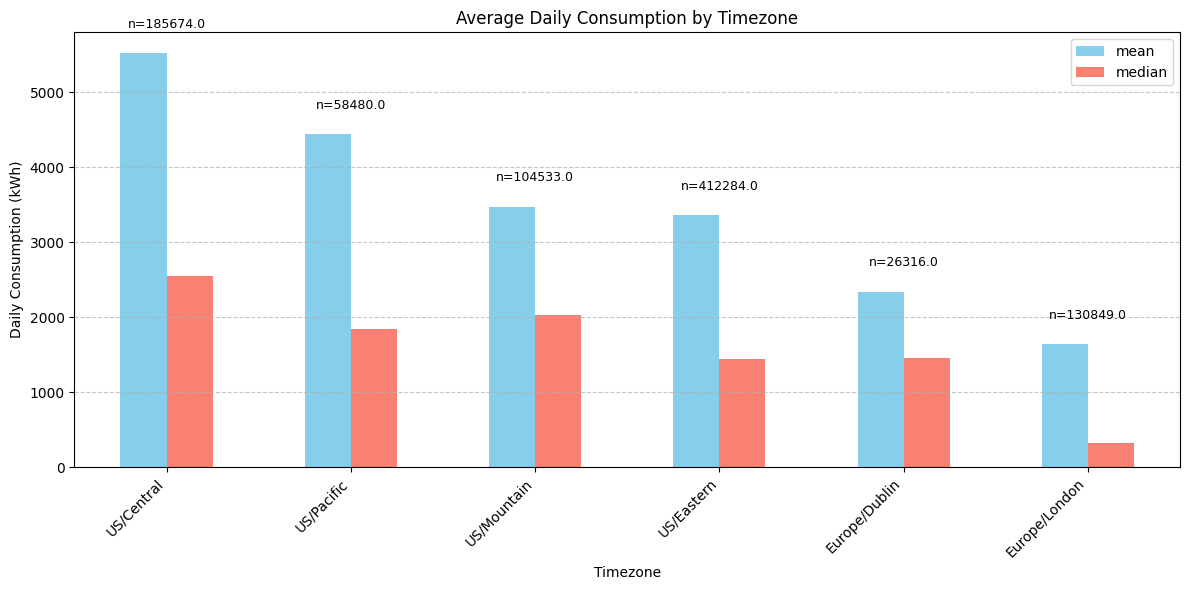

/tmp/ipykernel_23323/1428700241.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


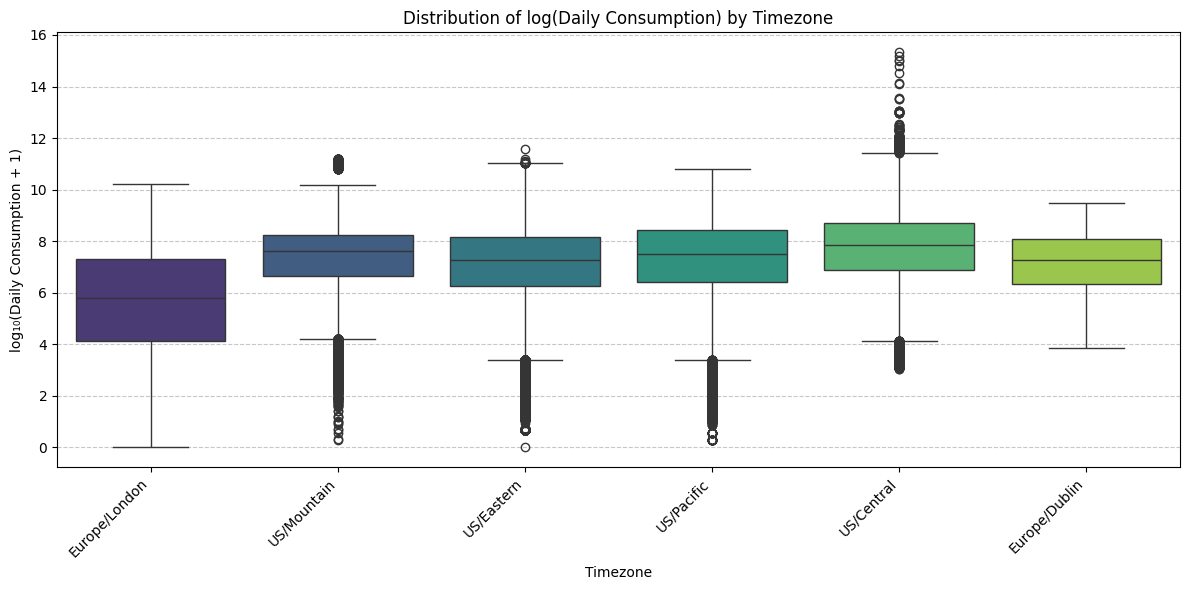

In [10]:
# Barplot of mean & median with building counts ---
fig, ax = plt.subplots(figsize=(12, 6))
tz_summary[["mean", "median"]].plot(kind="bar", ax=ax, color=["skyblue", "salmon"])
plt.title("Average Daily Consumption by Timezone")
plt.xlabel("Timezone")
plt.ylabel("Daily Consumption (kWh)")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Add building counts as annotations
for i, (idx, row) in enumerate(tz_summary.iterrows()):
    ax.text(i, max(row["mean"], row["median"]) + 300, f'n={row["count"]}', 
            ha='center', va='bottom', fontsize=9, color='black')

plt.tight_layout()
plt.show()

# Boxplot of log-transformed consumption by timezone ---
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=df,
    x="timezone",
    y="log_daily_consumption",
    palette="viridis"
)
plt.title("Distribution of log(Daily Consumption) by Timezone")
plt.xlabel("Timezone")
plt.ylabel("log₁₀(Daily Consumption + 1)")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


In [11]:
df.head()

date            building_id  daily_consumption site_id    sqft  \
0 2016-01-01  Robin_public_Carolina           2183.750   Robin  118231   
1 2016-01-02  Robin_public_Carolina           2205.563   Robin  118231   
2 2016-01-03  Robin_public_Carolina           2108.750   Robin  118231   
3 2016-01-04  Robin_public_Carolina           3536.562   Robin  118231   
4 2016-01-05  Robin_public_Carolina           3771.376   Robin  118231   

       sqm       timezone sub_primaryspaceusage primaryspaceusage       lat  \
0  10984.0  Europe/London               Library   Public services  51.51879   
1  10984.0  Europe/London               Library   Public services  51.51879   
2  10984.0  Europe/London               Library   Public services  51.51879   
3  10984.0  Europe/London               Library   Public services  51.51879   
4  10984.0  Europe/London               Library   Public services  51.51879   

   ...  windSpeed  is_outlier  month  year  day_of_week  is_weekend  \
0  ...   4.470833       False      1  2016            4       False   
1  ...   7.241667       False      1  2016            5        True   
2  ...   5.633333       False      1  2016            6        True   
3  ...   4.145833       False      1  2016            0       False   
4  ...   2.750000       False      1  2016            1       False   

   log_daily_consumption   log_sqm           size_bin  consumption_per_sqm  
0               7.689257  9.304286  (9288.0, 12776.2]             0.198812  
1               7.699191  9.304286  (9288.0, 12776.2]             0.200798  
2               7.654325  9.304286  (9288.0, 12776.2]             0.191984  
3               8.171193  9.304286  (9288.0, 12776.2]             0.321974  
4               8.235460  9.304286  (9288.0, 12776.2]             0.343352  

[5 rows x 26 columns]

In [12]:
df.drop(columns=['size_bin'], inplace=True)

In [13]:
df.head()

date            building_id  daily_consumption site_id    sqft  \
0 2016-01-01  Robin_public_Carolina           2183.750   Robin  118231   
1 2016-01-02  Robin_public_Carolina           2205.563   Robin  118231   
2 2016-01-03  Robin_public_Carolina           2108.750   Robin  118231   
3 2016-01-04  Robin_public_Carolina           3536.562   Robin  118231   
4 2016-01-05  Robin_public_Carolina           3771.376   Robin  118231   

       sqm       timezone sub_primaryspaceusage primaryspaceusage       lat  \
0  10984.0  Europe/London               Library   Public services  51.51879   
1  10984.0  Europe/London               Library   Public services  51.51879   
2  10984.0  Europe/London               Library   Public services  51.51879   
3  10984.0  Europe/London               Library   Public services  51.51879   
4  10984.0  Europe/London               Library   Public services  51.51879   

   ...  windDirection  windSpeed  is_outlier  month  year  day_of_week  \
0  ...     116.666667   4.470833       False      1  2016            4   
1  ...     166.666667   7.241667       False      1  2016            5   
2  ...     187.916667   5.633333       False      1  2016            6   
3  ...     177.083333   4.145833       False      1  2016            0   
4  ...     175.416667   2.750000       False      1  2016            1   

   is_weekend  log_daily_consumption   log_sqm  consumption_per_sqm  
0       False               7.689257  9.304286             0.198812  
1        True               7.699191  9.304286             0.200798  
2        True               7.654325  9.304286             0.191984  
3       False               8.171193  9.304286             0.321974  
4       False               8.235460  9.304286             0.343352  

[5 rows x 25 columns]

In [14]:
df.drop(columns=['consumption_per_sqm'], inplace=True)

In [15]:
df.head()

date            building_id  daily_consumption site_id    sqft  \
0 2016-01-01  Robin_public_Carolina           2183.750   Robin  118231   
1 2016-01-02  Robin_public_Carolina           2205.563   Robin  118231   
2 2016-01-03  Robin_public_Carolina           2108.750   Robin  118231   
3 2016-01-04  Robin_public_Carolina           3536.562   Robin  118231   
4 2016-01-05  Robin_public_Carolina           3771.376   Robin  118231   

       sqm       timezone sub_primaryspaceusage primaryspaceusage       lat  \
0  10984.0  Europe/London               Library   Public services  51.51879   
1  10984.0  Europe/London               Library   Public services  51.51879   
2  10984.0  Europe/London               Library   Public services  51.51879   
3  10984.0  Europe/London               Library   Public services  51.51879   
4  10984.0  Europe/London               Library   Public services  51.51879   

   ...  seaLvlPressure  windDirection  windSpeed  is_outlier  month  year  \
0  ...     1016.941667     116.666667   4.470833       False      1  2016   
1  ...      998.087500     166.666667   7.241667       False      1  2016   
2  ...      991.837500     187.916667   5.633333       False      1  2016   
3  ...      982.766667     177.083333   4.145833       False      1  2016   
4  ...      984.712500     175.416667   2.750000       False      1  2016   

   day_of_week  is_weekend  log_daily_consumption   log_sqm  
0            4       False               7.689257  9.304286  
1            5        True               7.699191  9.304286  
2            6        True               7.654325  9.304286  
3            0       False               8.171193  9.304286  
4            1       False               8.235460  9.304286  

[5 rows x 24 columns]